# bird data reading and plotting
### oregional code was done by Doruk 
### Modified by X. Liu on Oct 12, 2023 (from py to ipynb)

## !deep study (?)
##  (1) extend the data to 2021-2024
##  (2) make composed analysis (high dust events/ lower dust event ) and make comparison 
##  (3) time series of the dust events

In [91]:
# Instructions
# satellite data: Feb 20 & 21 2021 missing

# This version compares all the _START_END signals (i.e., surface measurements),
# with the Original and Modified (Marvin) model results as well as the satellite.

# May2022: So this code uses the data processed by my quick script. However then
# I moved on modifying Dylan's processing scripts, hence try to use that for
# profile comparisons.

# TODO: select comparison plot time index

# Only model surface information is used in this version.

# xr.open_mfdataset(files) automatically combines all the files. It worked for
# time dimension without any issues. It uses "dask" module and chunking which
# is super fast so it can handle large file sizes as well.

# Interpolation and advanced indexing is a bit complex 
# https://xarray.pydata.org/en/stable/user-guide/interpolation.html#advanced-interpolation

In [1]:
import pandas as pd
import xarray as xr
import numpy as np
import netCDF4
# import nc_time_axis
import matplotlib.pyplot as plt
import glob
import cmocean
import xskillscore as xs
# from sklearn.metrics import mean_squared_error

import h5py
from scipy.io import loadmat

# 1. Load Data

## 1.0 Load topography data (to mask ocean-dust data )

In [2]:
ds_topo_etopo1 = xr.open_dataset('/home/server/pi/homes/liux8/work/general_data/topography/etopo1.nc',mode='r')

/home/server/pi/homes/liux8/.conda/envs/dev_scipy/lib/python3.11/site-packages/xarray/coding/times.py:210: CFWarning: this date/calendar/year zero convention is not supported by CF
  cftime.num2date(num_dates, units, calendar, only_use_cftime_datetimes=True)
/home/server/pi/homes/liux8/.conda/envs/dev_scipy/lib/python3.11/site-packages/xarray/coding/times.py:724: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/server/pi/homes/liux8/.conda/envs/dev_scipy/lib/python3.11/site-packages/xarray/core/indexing.py:557: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  array = array.get_duck_array()


# 1.1 Load dust data (2021-2024)

In [29]:
## load 2021-2024 dust data
for iy in range(2021,2025):
    with h5py.File(f'/home/server/pi/homes/liux8/work/OBS/xliu_obs_process/dust_mat_files/dust_{iy}_MERRA2_hourly_v2.mat', 'r') as file:
        def print_attrs(name, obj):
            print(iy)
            print(name)
            for key, val in obj.attrs.items():
                print(f"    {key}: {val}")

        file.visititems(print_attrs)

        # 读取数据集
        if iy==2021:
            dust2021 = file['dust_cum'][:]
            latdus = file['latdus'][:]
            londus = file['londus'][:]
        else:
            dust2021 = np.concatenate((dust2021,file['dust_cum'][:]),axis=0)
            
tdim = dust2021.shape[0]
            

da_dust = xr.DataArray(dust2021, coords={'lon': londus[0,:], 'lat': latdus[0,:], 'time': np.arange(0,tdim*3600,3600)},
                  dims=['time', 'lat', 'lon'])

ds_dust = xr.Dataset({'dust_dens': da_dust})

ds_dust['time'] = pd.to_datetime(ds_dust['time'].values,unit='s')+pd.DateOffset(years=51)

# ds_dust_daily = ds_dust.groupby("time.dayofyear").mean(dim="time")

2021
dust_cum
    MATLAB_class: b'double'
2021
latdus
    MATLAB_class: b'double'
2021
londus
    MATLAB_class: b'double'
2022
dust_cum
    MATLAB_class: b'double'
2022
latdus
    MATLAB_class: b'double'
2022
londus
    MATLAB_class: b'double'
2023
dust_cum
    MATLAB_class: b'double'
2023
latdus
    MATLAB_class: b'double'
2023
londus
    MATLAB_class: b'double'
2024
dust_cum
    MATLAB_class: b'double'
2024
latdus
    MATLAB_class: b'double'
2024
londus
    MATLAB_class: b'double'


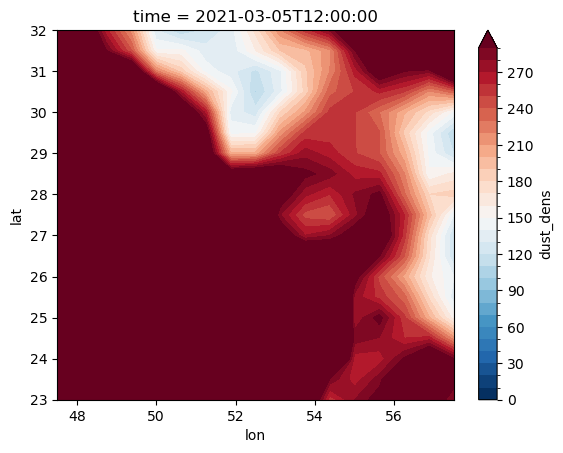

In [46]:
(ds_dust*1e6).dust_dens.sel(time=pd.to_datetime('2021-03-05 12:00:00')).plot.contourf(cmap='RdBu_r',levels=np.arange(0,300,10))

In [47]:
# [londusm,latdusm] = meshgrid(londus,latdus);
bathy_pg = ds_topo_etopo1.interp(LON=ds_dust.lon,LAT=ds_dust.lat);

mask_pg = bathy_pg.B_BATHY.copy();
mask_pg2 = mask_pg.where(mask_pg<0,np.nan)
mask_pg2 = mask_pg2.where(np.isnan(mask_pg2),1)
    
bathy_pg = bathy_pg.update({'mask':mask_pg2})

mask_pg = bathy_pg.B_BATHY.copy();
mask_pg3 = mask_pg.where(mask_pg>1,1)
mask_pg3 = mask_pg3.where(mask_pg<0,0)
    
bathy_pg = bathy_pg.update({'mask2':mask_pg3})

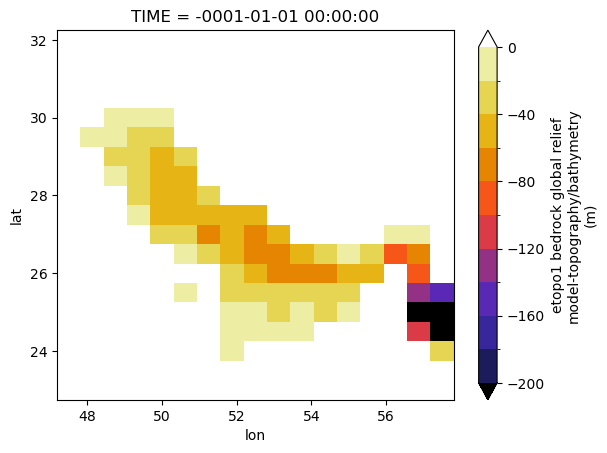

In [57]:
bathy_pg.B_BATHY.isel(TIME=0).plot(levels=np.arange(-200,20,20),cmap='CMRmap')

## 1.1 Load bird data

In [262]:
CLim_l=15
CLim_h=40
ms1=1
# file1='Nov_Dec_2020.csv'
# file1='3min_Jan_Mar_2021.csv' ;ptime=15
# file1='surf_processed/Jan_Mar_2021.csv' ;ptime=15

file1='~/work/OBS/xliu_obs_process/surf_processed/All_2021_3min_with_id.csv'; ptime=165
# file1='surf_processed/Jul_Sep_2021.csv'; ptime=220
# file1='surf_processed/Oct_Dec_2021.csv'

yr=file1[-21:-17]
# yr=file1[-13:-9]
df = pd.read_csv(file1,parse_dates=True,index_col='UTC_datetime')

#READ MARVIN'S MODIFIED MODEL RESULT AND ORIGINAL SHORTWAVE RAD

def RMSE(x,y):
    mse = np.square(np.subtract(x,y)).mean() 
    return np.sqrt(mse)

In [263]:
df

device_id    UTC_date  UTC_time           datatype  \
UTC_datetime                                                              
2021-01-01 05:17:57     203018  2021-01-01  05:17:57  SEND_ALL2_1Hz_END   
2021-01-01 05:22:49     203018  2021-01-01  05:22:49  SEND_ALL2_1Hz_END   
2021-01-01 05:23:24     203018  2021-01-01  05:23:24  SEND_ALL2_1Hz_END   
2021-01-01 05:24:40     203018  2021-01-01  05:24:40  SEND_ALL2_1Hz_END   
2021-01-01 05:25:09     203018  2021-01-01  05:25:09  SEND_ALL2_1Hz_END   
...                        ...         ...       ...                ...   
2021-07-30 13:20:03     201411  2021-07-30  13:20:03  SEND_ALL2_1Hz_END   
2021-07-30 13:21:27     201411  2021-07-30  13:21:27  SEND_ALL2_1Hz_END   
2021-07-30 13:22:02     201411  2021-07-30  13:22:02  SEND_ALL2_1Hz_END   
2021-07-30 13:23:07     201411  2021-07-30  13:23:07  SEND_ALL2_1Hz_END   
2021-07-30 13:23:37     201411  2021-07-30  13:23:37  SEND_ALL2_1Hz_END   

                     satcount  Latitude  Longitude  depth_m  \
UTC_datetime                                                  
2021-01-01 05:17:57       NaN       NaN        NaN     0.67   
2021-01-01 05:22:49       NaN       NaN        NaN     0.73   
2021-01-01 05:23:24       NaN       NaN        NaN     0.33   
2021-01-01 05:24:40       NaN       NaN        NaN     0.00   
2021-01-01 05:25:09       NaN       NaN        NaN     1.43   
...                       ...       ...        ...      ...   
2021-07-30 13:20:03       NaN       NaN        NaN     0.00   
2021-07-30 13:21:27       NaN       NaN        NaN     0.34   
2021-07-30 13:22:02       NaN       NaN        NaN     0.00   
2021-07-30 13:23:07       NaN       NaN        NaN     0.00   
2021-07-30 13:23:37       NaN       NaN        NaN     0.00   

                     conductivity_mS/cm  ext_temperature_C  \
UTC_datetime                                                 
2021-01-01 05:17:57          197.169571          22.250000   
2021-01-01 05:22:49          198.899933          22.218750   
2021-01-01 05:23:24          201.112518          22.179688   
2021-01-01 05:24:40          198.465652          22.187500   
2021-01-01 05:25:09          197.726700          22.171875   
...                                 ...                ...   
2021-07-30 13:20:03           89.812492          -1.000000   
2021-07-30 13:21:27           89.695786          -1.000000   
2021-07-30 13:22:02           88.632980          -1.000000   
2021-07-30 13:23:07           89.955643          -1.000000   
2021-07-30 13:23:37           89.276535          -1.000000   

                                    date  mask  Latitude_1  Longitude_1  \
UTC_datetime                                                              
2021-01-01 05:17:57  2021-01-01 05:17:57  True   24.626194    53.175003   
2021-01-01 05:22:49  2021-01-01 05:22:49  True   24.632069    53.192856   
2021-01-01 05:23:24  2021-01-01 05:23:24  True   24.631731    53.192963   
2021-01-01 05:24:40  2021-01-01 05:24:40  True   24.631260    53.195274   
2021-01-01 05:25:09  2021-01-01 05:25:09  True   24.630499    53.195320   
...                                  ...   ...         ...          ...   
2021-07-30 13:20:03  2021-07-30 13:20:03  True   26.075060    56.089737   
2021-07-30 13:21:27  2021-07-30 13:21:27  True   26.074387    56.091133   
2021-07-30 13:22:02  2021-07-30 13:22:02  True   26.074179    56.091438   
2021-07-30 13:23:07  2021-07-30 13:23:07  True   26.072668    56.091732   
2021-07-30 13:23:37  2021-07-30 13:23:37  True   26.072556    56.091072   

                     mask_1  
UTC_datetime                 
2021-01-01 05:17:57    True  
2021-01-01 05:22:49    True  
2021-01-01 05:23:24    True  
2021-01-01 05:24:40    True  
2021-01-01 05:25:09    True  
...                     ...  
2021-07-30 13:20:03    True  
2021-07-30 13:21:27    True  
2021-07-30 13:22:02    True  
2021-07-30 13:23:07    True  
2021-07-30 13:23:37    True  

[46695 rows x 15 columns]

In [266]:
# df1 = df.loc[df['device_id']==203013]

x = xr.DataArray(df.Longitude_1, dims="t")
y = xr.DataArray(df.Latitude_1, dims="t")
t = xr.DataArray(df.date, dims="t")
did = xr.DataArray(df.device_id, dims="t")
temp = xr.DataArray(df.ext_temperature_C, dims="t")
# conduc = xr.DataArray(df['conductivity_mS/cm'], dims="t")

ds_obs = xr.Dataset({
    'x': x,
    'y': y,
    't0': t,
    'id': did,
    'temp': temp,
    # 'cond': conduc
})

In [51]:
df.device_id.unique()

array([203018, 203013, 203014, 203034, 203029, 201420, 201410, 201411])

In [54]:
# ta = ds_obs.temp.where('id'==203018).groupby("t.dayofyear").mean(dim='t')
ta0 = ds_obs['temp'].where(ds_obs['id']==203018,drop=True).groupby("t.dayofyear").mean(dim='t')

In [360]:
ca0 = ds_obs['cond'].where(ds_obs['id']==203018,drop=True).groupby("t.dayofyear").mean(dim='t')

## 1.3 load SST (Satellite) data

In [397]:
with h5py.File('/home/server/pi/homes/liux8/work/OBS/xliu_obs_process/sst_clim_MUR.mat', 'r') as file:
    def print_attrs(name, obj):
        print(name)
        for key, val in obj.attrs.items():
            print(f"    {key}: {val}")

    file.visititems(print_attrs)

    # 读取数据集
    sst_clim = file['sst_clim'][:]
#     lon_clim = file['latdus'][:]
#     lat_clim = file['londus'][:]
lon0 = loadmat('/home/server/pi/homes/liux8/work/OBS/xliu_obs_process/sst_lonlat_MUR.mat')['lon']
lat0 = loadmat('/home/server/pi/homes/liux8/work/OBS/xliu_obs_process/sst_lonlat_MUR.mat')['lat']
ilon = loadmat('/home/server/pi/homes/liux8/work/OBS/xliu_obs_process/sst_ilon_ilat_MUR.mat')['ilon1']
jlat = loadmat('/home/server/pi/homes/liux8/work/OBS/xliu_obs_process/sst_ilon_ilat_MUR.mat')['jlat1']

lon_mur = lon0[ilon[0,0].astype(int)-1:ilon[-1,0].astype(int)]
lat_mur = lat0[jlat[0,0].astype(int)-1:jlat[-1,0].astype(int)]

sst_clim
    MATLAB_class: b'double'


In [398]:
da_mur_clim = xr.DataArray(sst_clim, coords={'lon': lon_mur[:,0], 'lat': lat_mur[:,0], 'time': np.arange(365)},
                  dims=['time', 'lat', 'lon'])

# da2_mur = da_mur.interp(lon=datasets_era[0].lonc,lat=datasets_era[0].latc,method='linear')

ds_mur_clim = xr.Dataset({'sst': da_mur_clim})
ds_mur_clim['time'] = pd.to_datetime(ds_mur_clim['time'].values,unit='D')+pd.DateOffset(years=51)

# get monthyly average 
# ds_mur_monthly = ds_mur.resample(time='1M').mean()

## 1.4 Load Model (Surface) data 

In [9]:
runname = '~/work/GETM/hpc2-files/GETM_shrad/getm/setups/era5frc_coldstart_01012017_era5v6/data_results_2021/';

# datasets_era_v6 = []
# for im in range(1,13): 
#     datatype = 'data/regions/mean_mon'+str(im)

#     data_name = runname+datatype
#     file_3d = data_name+'.nc'
    
#     print("  Opening %s  file "%file_3d)
#     ds = xr.open_dataset(file_3d,mode='r')
#     datasets_era_v6.append(ds)
    
datatype = 'data/regions/surface'

data_name = runname+datatype
file_3d = data_name+'.nc'

print("  Opening %s  file "%file_3d)
ds_sur_era_v6 = xr.open_dataset(file_3d,mode='r')

  Opening ~/work/GETM/hpc2-files/GETM_shrad/getm/setups/era5frc_coldstart_01012017_era5v6/data_results_2021/data/regions/surface.nc  file 


# 2. data Proc

## 2.1 get dust variation 2021-2024

In [98]:
ds_dust

<xarray.Dataset>
Dimensions:    (lon: 17, lat: 19, time: 27720)
Coordinates:
  * lon        (lon) float64 47.5 48.12 48.75 49.38 ... 55.62 56.25 56.88 57.5
  * lat        (lat) float64 23.0 23.5 24.0 24.5 25.0 ... 30.5 31.0 31.5 32.0
  * time       (time) datetime64[ns] 2021-01-01 ... 2024-02-28T23:00:00
Data variables:
    dust_dens  (time, lat, lon) float64 0.0002416 0.000225 ... 0.000111 0.000149

In [105]:
ds_dust_daily = ds_dust.groupby('time.date').mean(dim='time')
ds_dust_daily['date'] = pd.to_datetime(ds_dust_daily['date'])

In [111]:
ds_dust_daily_mean = ds_dust_daily.mean(dim='lon').mean(dim='lat')

(0.0, 0.0012)

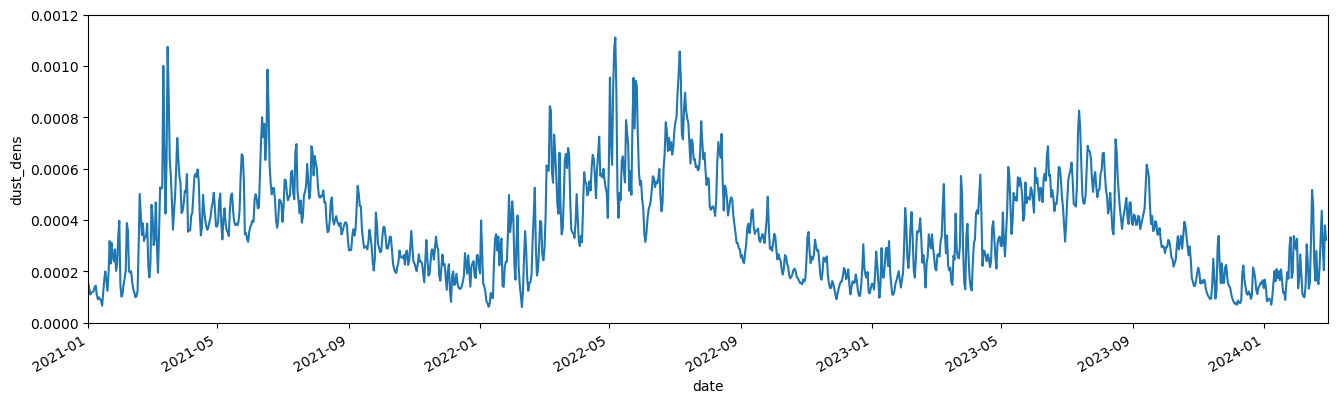

In [122]:
plt.figure(figsize=(16,4))
ds_dust_daily_mean.dust_dens.plot()
plt.xlim(pd.to_datetime(['2021-01-01','2024-03-01']))
plt.ylim(0,0.0012)

(0.0, 0.0012)

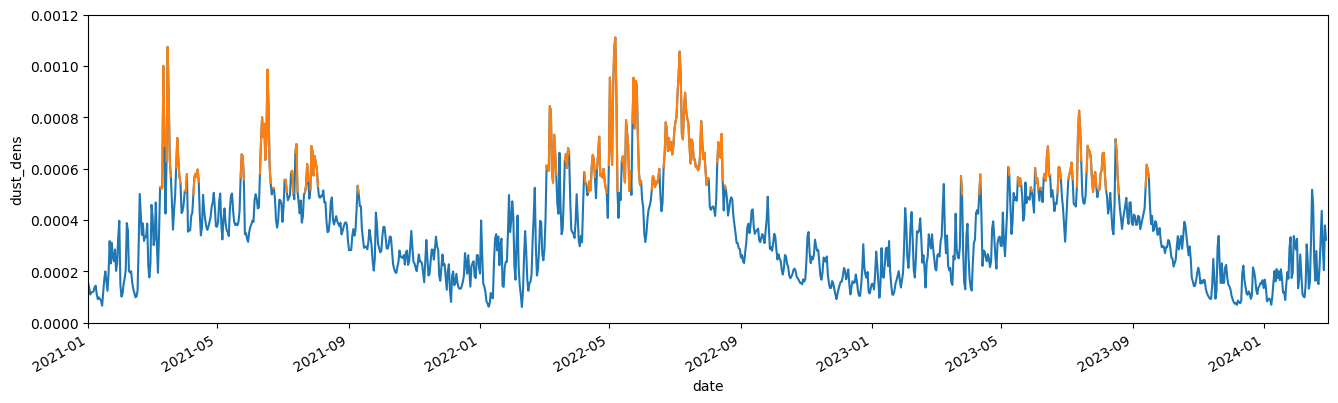

In [131]:
plt.figure(figsize=(16,4))
ds_dust_daily_mean.dust_dens.plot()
ds_dust_daily_mean.dust_dens.where(ds_dust_daily_mean.dust_dens>0.0005).plot()
plt.xlim(pd.to_datetime(['2021-01-01','2024-03-01']))
plt.ylim(0,0.0012)

(0.0, 0.0012)

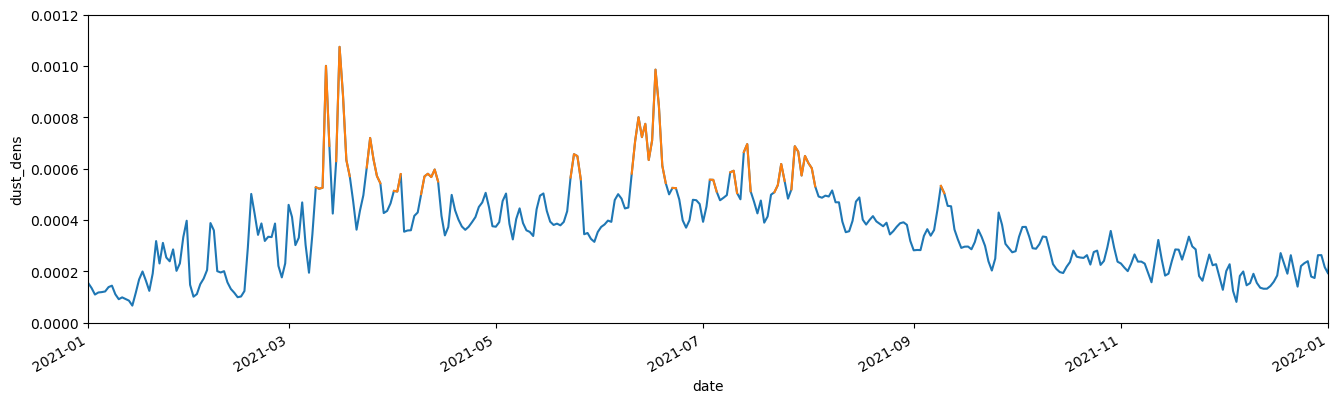

In [134]:
plt.figure(figsize=(16,4))
ds_dust_daily_mean.dust_dens.plot()
ds_dust_daily_mean.dust_dens.where(ds_dust_daily_mean.dust_dens>0.0005).plot()
plt.xlim(pd.to_datetime(['2021-01-01','2022-01-01']))
plt.ylim(0,0.0012)

(0.0, 0.0012)

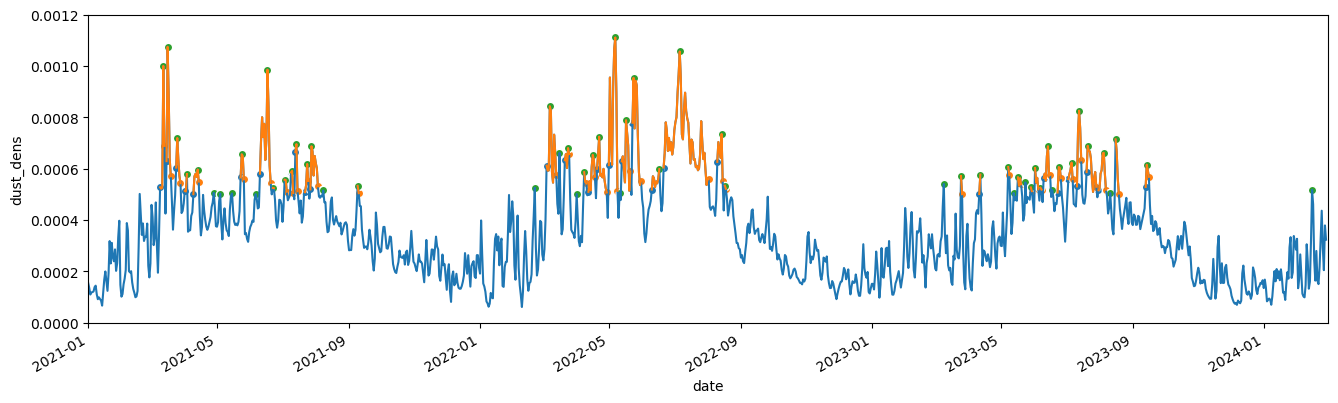

In [167]:
plt.figure(figsize=(16,4))
ds_dust_daily_mean.dust_dens.plot()
ds_dust_daily_mean.dust_dens.where(ds_dust_daily_mean.dust_dens>0.0005).plot()
plt.xlim(pd.to_datetime(['2021-01-01','2024-03-01']))
da_events[start_events].plot.scatter()
da_events[end_events].plot.scatter()
da_events[max_value_indices].plot.scatter()
plt.ylim(0,0.0012)

In [188]:
# pick up the events and find the maximum of each event
# the threshold is 0.0005 (kg/m^2)
da_events = ds_dust_daily_mean.dust_dens.where(ds_dust_daily_mean.dust_dens>0.0005)

data_array = da_events.values

# Find indices of non-NaN values
non_nan_indices = np.where(~np.isnan(data_array))[0]

# Find the start and end indices of each non-NaN chunk
start_indices = np.where(np.diff(non_nan_indices) != 1)[0] + 1
end_indices = np.append(start_indices[1:] - 1, non_nan_indices.size-1)

start_events = non_nan_indices[start_indices]
end_events = non_nan_indices[end_indices]

# Get the start and end times of each chunk
start_times = da_events.date[start_events]
end_times = da_events.date[end_events]

days_before = 5
days_after = 5

# Get the time of the maximum value in each chunk
# then, pick up the data 5days before and after the maximum date as a standard event
max_value_times = []
events_max_index = []
events_start_index = []
events_end_index = [] 
for start, end in zip(start_events, end_events):
    chunk_values = data_array[start:end+1]  # Extract values within the chunk
    max_value_index = start + np.argmax(chunk_values)  # Find index of maximum value within chunk
    max_value_time = da_events.date[max_value_index]  # Get time corresponding to maximum value index
    max_value_times.append(max_value_time)
    events_max_index.append(max_value_index)
    
    # Extract data and time 5 days before and after the maximum value
    start_index = max_value_index - days_before
    end_index = max_value_index + days_after
    
    events_start_index.append(start_index)
    events_end_index.append(end_index)

# new_da = xr.DataArray(np.array(chunk_data), coords={'time': chunk_time}, dims=['chunks', 'time'])


In [215]:
chunk_data = []
chunk_time = []
for start, end in zip(events_start_index, events_end_index):
    chunk_data.append(ds_dust_daily_mean.dust_dens[start:end+1])
    chunk_time.append(ds_dust_daily_mean.date[start:end+1])
    
chunks = np.arange(1, len(chunk_data) + 1)
times = np.arange(-days_before, days_after + 1)

# Create the new dataset
events_ds = xr.Dataset()

# Add chunk_data and chunk_time as variables to the new dataset
events_ds['chunk_data'] = (('chunks', 'time'), np.array(chunk_data))
events_ds['chunk_time'] = (('chunks', 'time'), np.array(chunk_time))

# Assign coordinates for 'chunks' and 'time' dimensions
events_ds['chunks'] = chunks
events_ds['time'] = times

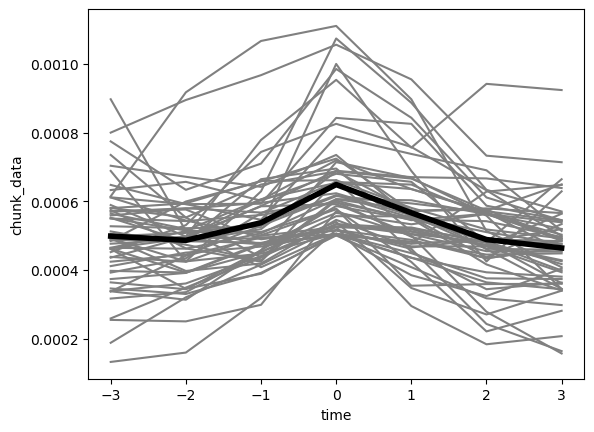

In [229]:
for i in np.arange(len(chunk_data)):
    events_ds.chunk_data[i,2:9].plot(color='grey')
events_ds.mean(dim='chunks').chunk_data[2:9].plot(linewidth=4,color='k')

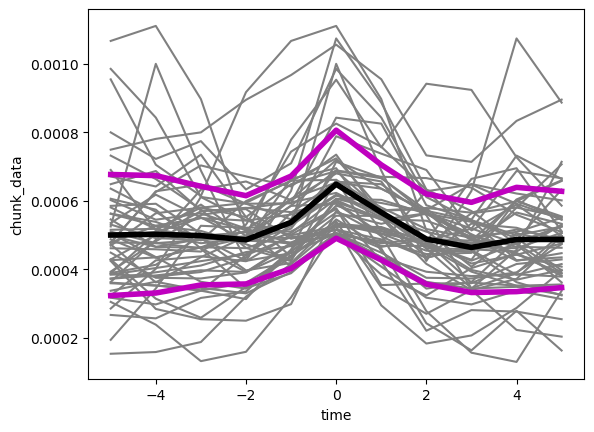

In [236]:
for i in np.arange(len(chunk_data)):
    events_ds.chunk_data[i,:].plot(color='grey')
events_ds.mean(dim='chunks').chunk_data.plot(linewidth=4,color='k')
(events_ds.mean(dim='chunks')+events_ds.std(dim='chunks')).chunk_data.plot(linewidth=4,color='m')
(events_ds.mean(dim='chunks')-events_ds.std(dim='chunks')).chunk_data.plot(linewidth=4,color='m')

In [245]:
events_ds.chunk_data[i,:].data

array([0.00019406, 0.0003439 , 0.00052711, 0.00052142, 0.00052508,
       0.00099998, 0.00068831, 0.00042452, 0.00062879, 0.00107415,
       0.00088682])

(-3.0, 3.0)

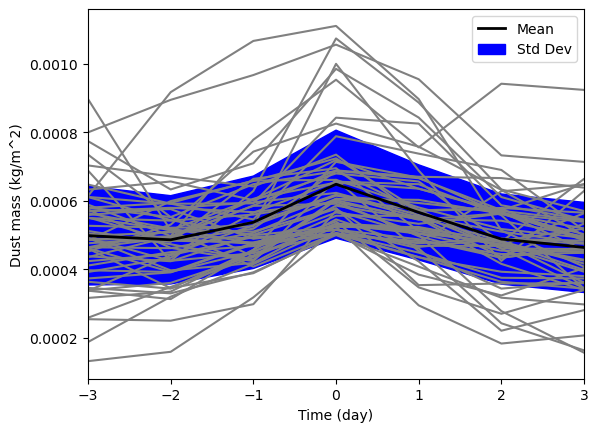

In [261]:
mean_data = events_ds.mean(dim='chunks').chunk_data
std_data = events_ds.std(dim='chunks').chunk_data

for i in np.arange(len(chunk_data)):
    plt.plot(events_ds['time'], events_ds.chunk_data[i,:].data,color='grey')

plt.plot(events_ds['time'], mean_data, color='black', label='Mean',linewidth=2)

# Plot the standard deviation as a shaded grey area
plt.fill_between(events_ds['time'], mean_data - std_data, mean_data + std_data, color='b', label='Std Dev')
plt.xlabel('Time (day)')
plt.ylabel('Dust mass (kg/m^2)')
plt.legend()
plt.xlim(-3,3)

## 2.2 get bird data

In [331]:
ds_obs

<xarray.Dataset>
Dimensions:  (t: 46695)
Coordinates:
  * t        (t) datetime64[ns] 2021-01-01T05:17:57 ... 2021-07-30T13:23:37
Data variables:
    x        (t) float64 53.18 53.19 53.19 53.2 53.2 ... 56.09 56.09 56.09 56.09
    y        (t) float64 24.63 24.63 24.63 24.63 ... 26.07 26.07 26.07 26.07
    t0       (t) object '2021-01-01 05:17:57' ... '2021-07-30 13:23:37'
    id       (t) int64 203018 203018 203018 203018 ... 201411 201411 201411
    temp     (t) float64 22.25 22.22 22.18 22.19 22.17 ... nan nan nan nan nan

### 2.2.1 first try (absolute temperature)

In [348]:
# ds_obs.plot.scatter(x=x.where(x!=0, drop=True),y=y.where(x!=0, drop=True))
# ds_obs.plot.scatter(x=x,y=y)
# ds_obs

x_data = ds_obs['x']
y_data = ds_obs['y']
t_data = ds_obs['temp']
# t_data[t_data>1e5] = np.nan
# t_data[t_data<=0] = np.nan
# t_data[t_data==0] = np.nan

mask = (x_data != 0) & (y_data != 0) & (t_data<1e5) & (t_data>10) 


x_filtered = x_data[mask]
y_filtered = y_data[mask]
t_filtered = t_data[mask]

# plt.scatter(x_filtered, y_filtered)
# plt.plot(t_filtered[30700:30800])
# plt.plot(t_data[30700:30800])

In [351]:
t_filtered_daily = t_filtered.groupby('t.dayofyear').mean(dim='t')

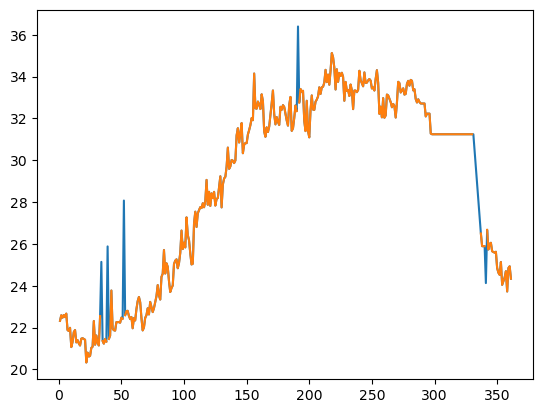

In [354]:
# t_filtered.groupby('t.dayofyear').mean(dim='t').plot()
x_data_array = t_filtered_daily.dayofyear.values
y_data_array = t_filtered_daily.values

df_unspike = main(x_data_array,y_data_array)

plt.plot(x_data_array,y_data_array)
plt.plot(x_data_array,df_unspike['y_remove_outliers'])

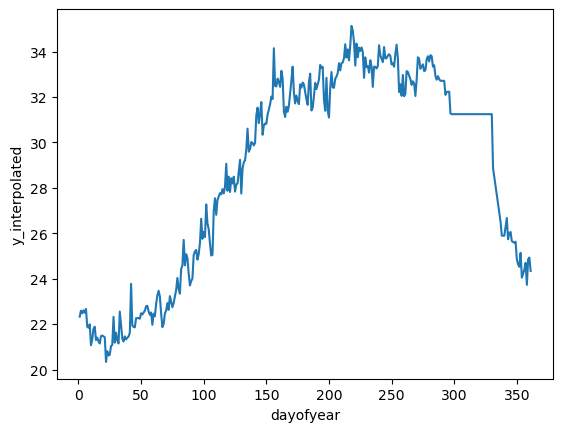

In [363]:
t_filtered_unspike = xr.DataArray(df_unspike['y_interpolated'], coords=t_filtered_daily.coords, dims=t_filtered_daily.dims)
t_filtered_unspike.plot()

### 2.2.2 Second try (temperature anomalies with respect to SST CLIM)

In [402]:
# idplt = 203018

# x = ds_obs.x.where(ds_obs['id']==idplt,drop=True)
# y = ds_obs.y.where(ds_obs['id']==idplt,drop=True)
# t = ds_obs.t.where(ds_obs['id']==idplt,drop=True)

x = ds_obs.x
y = ds_obs.y
t = ds_obs.t
# ds_obs

# =ds_sur_era_v6.temp.interp(lonc=x,latc=y,time=t) #original

# sat_t_tag1=sst.interp(time=t,lat=y,lon=x)

sat_t_tag1_clim = ds_mur_clim.sst.interp(time=t,lat=y,lon=x)-273.15


In [491]:
sst_basin_avg = (ds_mur_clim.sst-273.15).mean(dim='lon').mean(dim='lat')
sst_basin_avg

<xarray.DataArray 'sst' (time: 365)>
array([21.33683168, 21.28904089, 21.27569175, 21.23431195, 21.15185047,
       20.9936225 , 20.86690376, 20.79899754, 20.75678005, 20.64912477,
       20.62619351, 20.52222994, 20.38393588, 20.30346304, 20.16803855,
       20.09361979, 20.02984405, 20.0034086 , 19.92624259, 19.85553025,
       19.83699264, 19.74542662, 19.72447316, 19.68854202, 19.67099944,
       19.63475094, 19.65504578, 19.63718752, 19.57137431, 19.55364378,
       19.49959496, 19.4570244 , 19.41256837, 19.34033239, 19.28620055,
       19.2546073 , 19.26347631, 19.33300257, 19.37335508, 19.3175043 ,
       19.29269413, 19.28857776, 19.35592865, 19.40950421, 19.41212125,
       19.4462494 , 19.4647837 , 19.48535775, 19.51925031, 19.53191644,
       19.55266358, 19.52676835, 19.47783078, 19.46258711, 19.48509449,
       19.55112854, 19.64335624, 19.71771367, 19.78064863, 19.80183151,
       19.88019143, 19.94431087, 20.02126129, 20.0617056 , 20.00611807,
       20.03839945, 20.19769698, 20.28949408, 20.41380642, 20.55031922,
       20.62598133, 20.69205234, 20.74825303, 20.78063334, 20.85757137,
       20.93797023, 20.94551109, 20.98824436, 21.02507105, 21.02533533,
       21.04461255, 21.02175424, 21.08963421, 21.24347474, 21.38157688,
       21.51587942, 21.6348842 , 21.76041153, 21.83582806, 21.82669782,
       21.86761831, 21.8986627 , 21.98131058, 22.09382252, 22.2864303 ,
       22.44592991, 22.53258837, 22.64730571, 22.78074787, 22.95797651,
...
       32.07390814, 31.98811865, 31.94219622, 31.79457612, 31.66831376,
       31.58423864, 31.55169214, 31.5331806 , 31.45604265, 31.40576096,
       31.39562081, 31.2816925 , 31.15819895, 31.05248486, 30.96924056,
       30.89602717, 30.84624855, 30.80583542, 30.70581403, 30.59505601,
       30.51354821, 30.42181784, 30.32845987, 30.24532329, 30.20686634,
       30.13562694, 30.05507484, 30.01245956, 29.90056006, 29.78222006,
       29.61478367, 29.49066784, 29.42004506, 29.37437199, 29.33576803,
       29.22852826, 29.14226952, 29.04622874, 28.90209694, 28.81044297,
       28.71145564, 28.58822372, 28.4114664 , 28.2723728 , 28.11691147,
       27.99446111, 27.86426316, 27.77191103, 27.67686385, 27.5445364 ,
       27.40904242, 27.22505016, 27.07540368, 26.94734995, 26.84354317,
       26.75908812, 26.62287773, 26.49822753, 26.36669625, 26.19413862,
       26.07230659, 25.88402431, 25.69721642, 25.55633904, 25.44013183,
       25.31513866, 25.19878465, 25.06676856, 24.93997802, 24.84304913,
       24.66723015, 24.51512939, 24.41392215, 24.3247188 , 24.24509687,
       24.12568526, 24.00792886, 23.85026704, 23.70366801, 23.53619621,
       23.40752269, 23.28913532, 23.15356665, 23.03494575, 22.92665145,
       22.82754148, 22.71507763, 22.59124006, 22.46129872, 22.38452688,
       22.35025553, 22.29406709, 22.22278082, 22.12402841, 22.0189441 ,
       21.90624877, 21.79692014, 21.75402375, 21.68910814, 21.61835268])
Coordinates:
  * time     (time) datetime64[ns] 2021-01-01 2021-01-02 ... 2021-12-31

In [413]:
sat_t_tag1_clim

x_data = ds_obs['x']
y_data = ds_obs['y']
t_data = ds_obs['temp']
tanom_data = ds_obs['temp']-sat_t_tag1_clim
# t_data[t_data>1e5] = np.nan
# t_data[t_data<=0] = np.nan
# t_data[t_data==0] = np.nan

mask = (x_data != 0) & (y_data != 0) & (t_data<1e5) & (t_data>10) & (~np.isnan(tanom_data))

x_filtered = x_data[mask]
y_filtered = y_data[mask]
tanom_filtered = tanom_data[mask]


In [414]:
tanom_filtered_daily = tanom_filtered.groupby('t.dayofyear').mean(dim='t')

In [467]:
t = np.arange(1,362)

tanom_filtered_daily_interp = tanom_filtered_daily.interp(dayofyear=t,method='nearest')

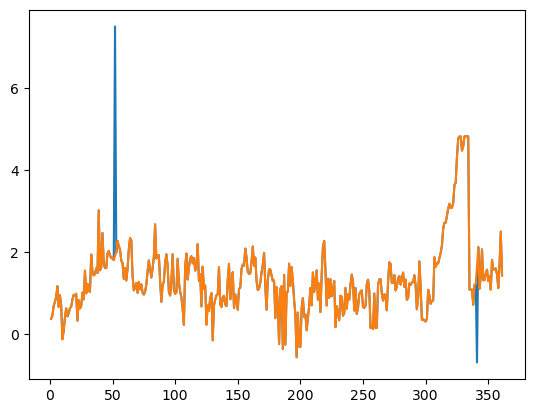

In [469]:
x_data_array = tanom_filtered_daily_interp.dayofyear.values
y_data_array = tanom_filtered_daily_interp.values

df_tanom_unspike = main(x_data_array,y_data_array)

plt.plot(x_data_array,y_data_array)
plt.plot(x_data_array,df_tanom_unspike['y_interpolated'])

In [471]:
tanom_filtered_unspike = xr.DataArray(df_tanom_unspike['y_interpolated'], 
                                      coords=tanom_filtered_daily_interp.coords, 
                                      dims=tanom_filtered_daily_interp.dims)
tanom_filtered_unspike

<xarray.DataArray 'y_interpolated' (dayofyear: 361)>
array([ 0.37323092,  0.45463908,  0.68520252,  0.78572713,  0.90461585,
        1.16821892,  0.6658484 ,  0.94797927,  0.70114864, -0.12429005,
        0.07582545,  0.40222313,  0.62615438,  0.43228144,  0.50795464,
        0.63175959,  0.67018689,  0.84409249,  0.95970788,  0.94244767,
        0.98451497,  0.32849058,  0.82817503,  0.62438748,  0.69240073,
        1.01364641,  0.84749808,  1.54729837,  0.99209417,  1.22585156,
        1.05203771,  1.03122807,  1.93951967,  1.5091038 ,  1.43254445,
        1.46336986,  1.60559893,  1.49185822,  3.01735032,  1.55438436,
        1.62265435,  2.46584882,  1.72010994,  1.61273162,  1.60869599,
        1.97044911,  2.0243897 ,  1.92330701,  1.85087163,  1.86162624,
        1.80352907,  1.8972737 ,  1.99101832,  2.27360503,  2.14867956,
        2.05744642,  1.78731554,  1.7360281 ,  1.34691089,  1.6144965 ,
        1.30812548,  1.58895531,  2.06246734,  2.34013993,  2.28286518,
        1.42558757,  1.06533124,  1.12844324,  1.24343754,  1.00478719,
        1.27529159,  1.09110148,  1.21361908,  1.01055849,  0.96424375,
        1.03296539,  1.2111254 ,  1.53450944,  1.79613899,  1.58518315,
        1.37984795,  1.60284119,  1.87888014,  2.67566981,  1.84375082,
        1.91814744,  1.92260656,  1.29202588,  0.78799214,  1.19114071,
        1.27966757,  1.7369205 ,  1.9463504 ,  1.67417971,  1.02611691,
        0.94110969,  1.28603204,  1.94665227,  1.09145581,  0.98029465,
...
        0.81598249,  0.97096883,  0.94140502,  0.58058562,  1.27290982,
        1.74983749,  1.70741382,  1.24519282,  1.24519282,  1.44016165,
        1.06613937,  1.15278629,  1.35727979,  1.41571813,  1.20849402,
        1.36531167,  1.49939313,  1.15141143,  1.32883008,  0.83765127,
        0.87790274,  1.2336049 ,  1.19777632,  1.25687586,  1.26668492,
        1.43496592,  1.18374976,  0.60563913,  0.87937902,  1.77230959,
        1.15129276,  0.34886024,  0.36977414,  0.33272128,  0.30594387,
        0.36666382,  1.07939762,  0.93641829,  0.73932853,  0.81459864,
        0.81459864,  1.8739689 ,  1.63772312,  1.72666645,  1.72666645,
        1.85325322,  1.97901633,  2.16192047,  2.57322548,  2.71723431,
        2.71190702,  2.89073638,  3.05784824,  3.17908284,  3.07312803,
        3.08235186,  3.19289359,  3.63359104,  3.69260537,  4.32117869,
        4.76907579,  4.81636979,  4.81636979,  4.47185869,  4.57807817,
        4.81953009,  4.81953009,  4.81953009,  4.81953009,  1.08587611,
        1.08587611,  1.08587611,  0.71462042,  1.19875548,  1.22192313,
        1.6715201 ,  2.12111707,  1.1088551 ,  1.41165309,  2.06607508,
        1.31592215,  1.31592215,  1.48785323,  1.57224254,  1.29201495,
        1.41441525,  1.08656457,  1.80883311,  1.57718713,  1.57718713,
        1.60425721,  1.45598319,  1.12184386,  1.71541075,  2.49982595,
        1.42993045])
Coordinates:
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 355 356 357 358 359 360 361

## 2.3 composite analysis

In [505]:
tchunk = []
sst_clim_chunk = []
# chunk_time = []
for start, end in zip(events_start_index, events_end_index):
    if t_filtered_unspike.sel(dayofyear=slice(start,end)).size!=0:
        tchunk.append(t_filtered_unspike.sel(dayofyear=slice(start,end+6)))
        sst_clim_chunk.append(sst_basin_avg.isel(time=slice(start,end+7)))
    # chunk_time.append(ds_dust_daily_mean.date[start:end+1])

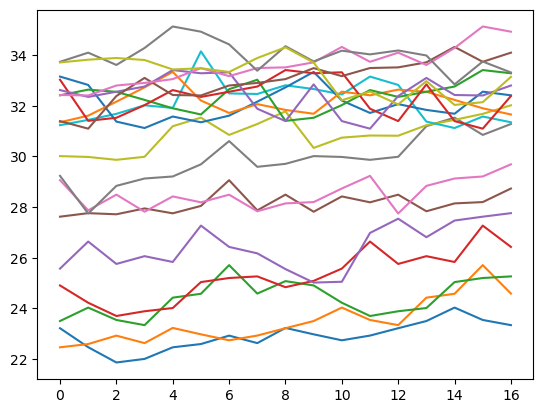

In [506]:
plt.plot(np.array(tchunk).T)

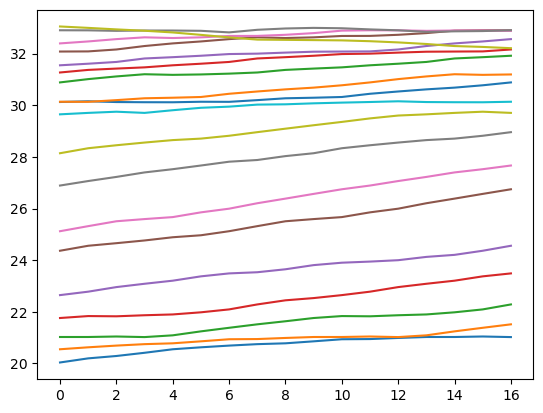

In [507]:
plt.plot(np.array(sst_clim_chunk).T)

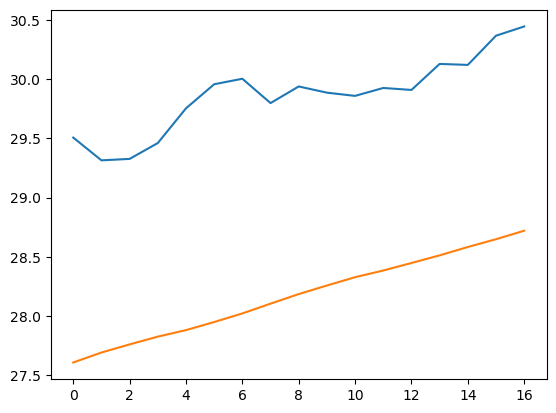

In [508]:
# plt.plot((np.array(tchunk)-np.array(sst_clim_chunk)).mean(axis=0))
plt.plot((np.array(tchunk)).mean(axis=0))
plt.plot(np.array(sst_clim_chunk).mean(axis=0))

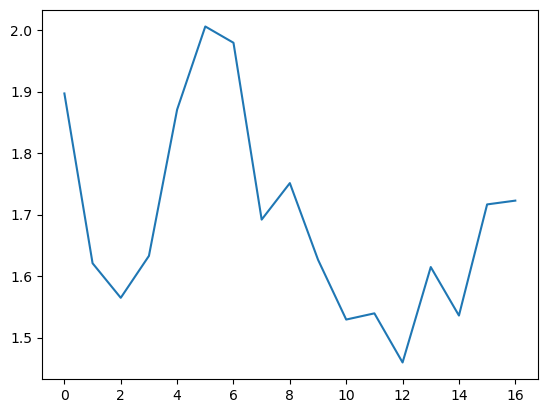

In [510]:
plt.plot((np.array(tchunk)-np.array(sst_clim_chunk)).mean(axis=0))


## using anomalies to do composite analysis

In [472]:
tanom_chunk = []
# chunk_time = []
icount=0
for start, end in zip(events_start_index, events_end_index):
    if tanom_filtered_unspike.sel(dayofyear=slice(start,end)).size!=0:
        icount=icount+1
        tanom_chunk.append(tanom_filtered_unspike.sel(dayofyear=slice(start,end+2)))
    # chunk_time.append(ds_dust_daily_mean.date[start:end+1])
print(icount)

19


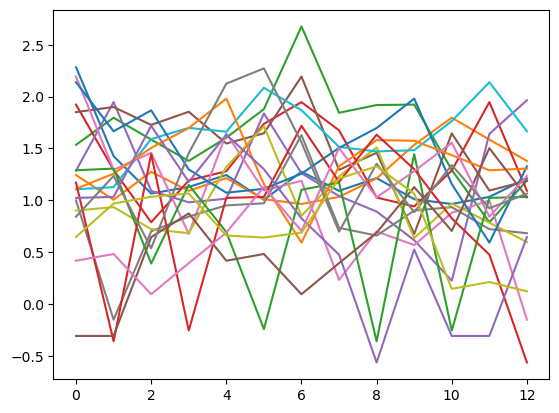

In [478]:
plt.plot(np.array(tanom_chunk).T)

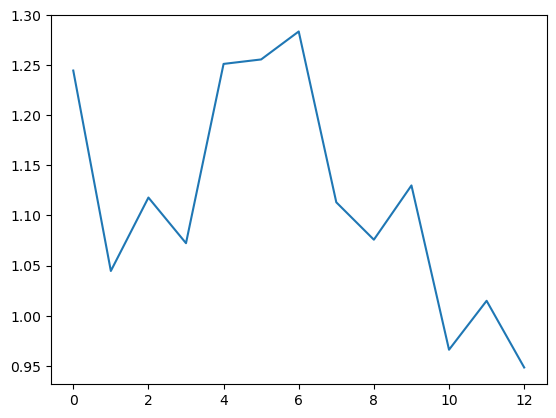

In [479]:
plt.plot(np.array(tanom_chunk).mean(axis=0))

## 3. functions

In [421]:
## remove spikes
import sys
import logging

logging.basicConfig(datefmt='%H:%M:%S',
                    stream=sys.stdout, level=logging.DEBUG,
                    format='%(asctime)s %(message)s')

# Distance away from the FBEWMA that data should be removed.
DELTA = 2

# clip data above this value:
HIGH_CLIP = 7

# clip data below this value:
LOW_CLIP = -1

# random values above this trigger a spike:
RAND_HIGH = 0.98

# random values below this trigger a negative spike:
RAND_LOW = 0.02

# How many samples to run the FBEWMA over.
SPAN = 10

# spike amplitude
SPIKE = 2


def clip_data(unclipped, high_clip, low_clip):
    ''' Clip unclipped between high_clip and low_clip. 
    unclipped contains a single column of unclipped data.'''
    
    # convert to np.array to access the np.where method
    np_unclipped = np.array(unclipped)
    # clip data above HIGH_CLIP or below LOW_CLIP
    cond_high_clip = (np_unclipped > HIGH_CLIP) | (np_unclipped < LOW_CLIP)
    np_clipped = np.where(cond_high_clip, np.nan, np_unclipped)
    return np_clipped.tolist()


def create_sample_data(x,y):
    ''' Create sine wave, amplitude +/-2 with random spikes. '''
    # x = np.linspace(0, 2*np.pi, 1000)
    # y = 2 * np.sin(x)
    # x = t_filtered.groupby('t.dayofyear').mean(dim='t').dayofyear.values[0:-2]
    # y = t_filtered.groupby('t.dayofyear').mean(dim='t').values[0:-2]
    df = pd.DataFrame(list(zip(x,y)), columns=['x', 'y'])
    df['rand'] = np.random.random_sample(len(x),)
    # create random positive and negative spikes
    cond_spike_high = (df['rand'] > RAND_HIGH)
    df['spike_high'] = np.where(cond_spike_high, SPIKE, 0)
    cond_spike_low = (df['rand'] < RAND_LOW)
    df['spike_low'] = np.where(cond_spike_low, -SPIKE, 0)
    # df['y_spikey'] = df['y'] + df['spike_high'] + df['spike_low']
    df['y_spikey'] = df['y'] 
    return df


def ewma_fb(df_column, span):
    ''' Apply forwards, backwards exponential weighted moving average (EWMA) to df_column. '''
    # Forwards EWMA.
    fwd = pd.Series.ewm(df_column, span=span).mean()
    # Backwards EWMA.
    bwd = pd.Series.ewm(df_column[::-1],span=10).mean()
    # Add and take the mean of the forwards and backwards EWMA.
    stacked_ewma = np.vstack(( fwd, bwd[::-1] ))
    fb_ewma = np.mean(stacked_ewma, axis=0)
    return fb_ewma
    
    
def remove_outliers(spikey, fbewma, delta):
    ''' Remove data from df_spikey that is > delta from fbewma. '''
    np_spikey = np.array(spikey)
    np_fbewma = np.array(fbewma)
    cond_delta = (np.abs(np_spikey-np_fbewma) > delta)
    np_remove_outliers = np.where(cond_delta, np.nan, np_spikey)
    return np_remove_outliers

    
def spike_removing(x0,y0):
    df = create_sample_data(x0,y0)

    df['y_clipped'] = clip_data(df['y_spikey'].tolist(), HIGH_CLIP, LOW_CLIP)
    df['y_ewma_fb'] = ewma_fb(df['y_clipped'], SPAN)
    df['y_remove_outliers'] = remove_outliers(df['y_clipped'].tolist(), df['y_ewma_fb'].tolist(), DELTA)
    df['y_interpolated'] = df['y_remove_outliers'].interpolate()
    
    # ax = df.plot(x='x', y='y_spikey', color='blue', alpha=0.5)
    # ax2 = df.plot(x='x', y='y_interpolated', color='black', ax=ax)
    # ax2 = df.plot(x='x', y='y_ewma_fb', color='black', ax=ax)
    return df
# main()

# ################OLD stuff

Text(0.5, 1.0, '203018')

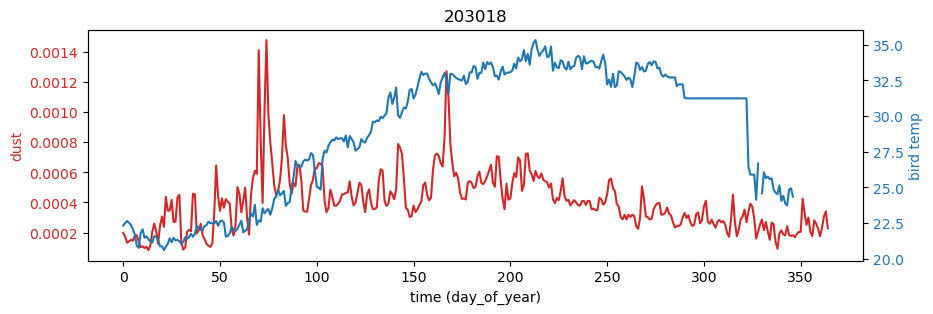

In [441]:
idplt = 203018

ta0 = ds_obs['temp'].where(ds_obs['id']==idplt,drop=True).groupby("t.dayofyear").mean(dim='t')

ta0[ta0<5]=np.nan

# dustplt = ds_dust_daily.dust_dens.mean(dim="lon").mean(dim="lat").data
dustplt = (ds_dust_daily.dust_dens*bathy_pg.mask.isel(TIME=0)).mean(dim="lon").mean(dim="lat").data

fig, ax1 = plt.subplots(figsize=(10,3))

color = 'tab:red'
ax1.set_xlabel('time (day_of_year)')
ax1.set_ylabel('dust', color=color)
ax1.plot(dustplt2, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('bird temp', color=color)  # we already handled the x-label with ax1
ax2.plot(ta0, color=color)
ax2.tick_params(axis='y', labelcolor=color)
plt.title(str(idplt))


Text(0.5, 1.0, '203018')

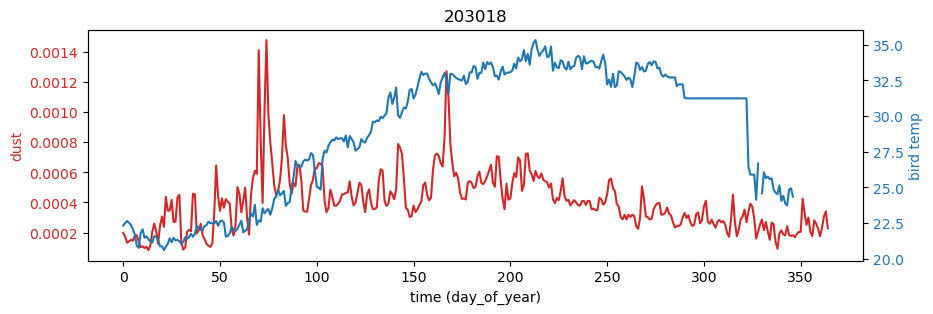

In [442]:
idplt = 203018

ta0 = ds_obs['temp'].where(ds_obs['id']==idplt,drop=True).groupby("t.dayofyear").mean(dim='t')

ta0[ta0<5]=np.nan

dust_msk = ds_dust_daily.dust_dens*bathy_pg.mask.isel(TIME=0)

dustplt = dust_msk.mean(dim="lon").mean(dim="lat").data

fig, ax1 = plt.subplots(figsize=(10,3))

color = 'tab:red'
ax1.set_xlabel('time (day_of_year)')
ax1.set_ylabel('dust', color=color)
ax1.plot(dustplt, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('bird temp', color=color)  # we already handled the x-label with ax1
ax2.plot(ta0, color=color)
ax2.tick_params(axis='y', labelcolor=color)
plt.title(str(idplt))

Text(0.5, 1.0, '203018')

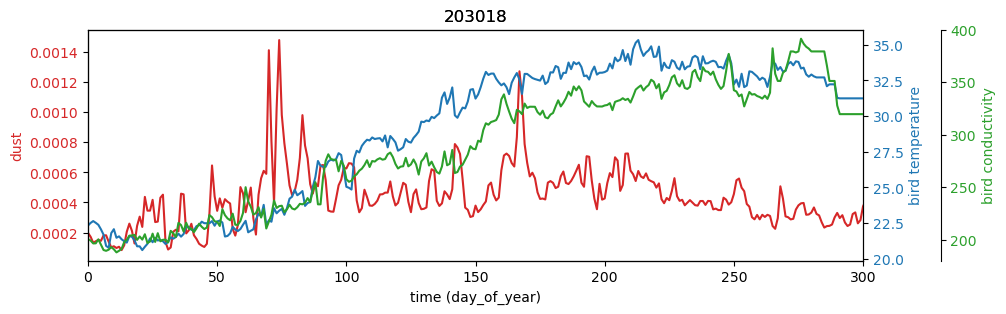

In [443]:
idplt = 203018

ta0 = ds_obs['temp'].where(ds_obs['id']==idplt,drop=True).groupby("t.dayofyear").mean(dim='t')

ta0[ta0<5]=np.nan

dust_msk = ds_dust_daily.dust_dens*bathy_pg.mask.isel(TIME=0)

dustplt = dust_msk.mean(dim="lon").mean(dim="lat").data

fig, ax1 = plt.subplots(figsize=(10,3))

color = 'tab:red'
ax1.set_xlabel('time (day_of_year)')
ax1.set_ylabel('dust', color=color)
ax1.plot(dustplt, color=color)
# ax1.plot(ta0, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('bird temperature', color=color)  # we already handled the x-label with ax1
ax2.plot(ta0, color=color)
ax2.tick_params(axis='y', labelcolor=color)
# ax2.set_ylim(180,400)
ax2.set_xlim(0,300)
plt.title(str(idplt))

ax3 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

ax3.spines.right.set_position(("axes", 1.1))

color = 'tab:green'
ax3.set_ylabel('bird conductivity', color=color)  # we already handled the x-label with ax1
ax3.plot(ca0, color=color)
ax3.tick_params(axis='y', labelcolor=color)
ax3.set_ylim(180,400)
ax3.set_xlim(0,300)
plt.title(str(idplt))

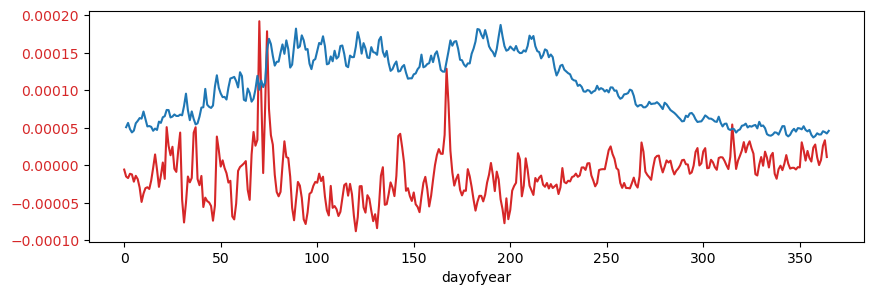

In [125]:
fig, ax1 = plt.subplots(figsize=(10,3))

color = 'tab:red'
ax1.set_xlabel('time (day_of_year)')
ax1.set_ylabel('dust', color=color)
ax1.plot(dustplt-da_dust_clim_avg.data, color=color)
ax1.tick_params(axis='y', labelcolor=color)

da_dust_clim_avg.plot()

Satellite vs. bird: 0.8595532839177971
Orig model vs. bird: 1.1304084782887152
Modified model vs. bird: 1.271610235329639


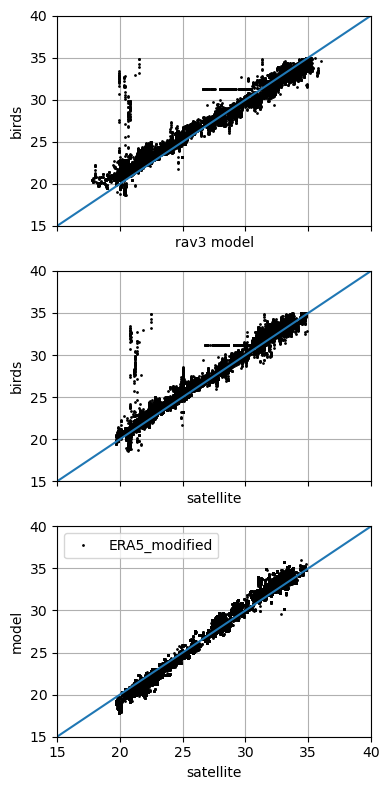

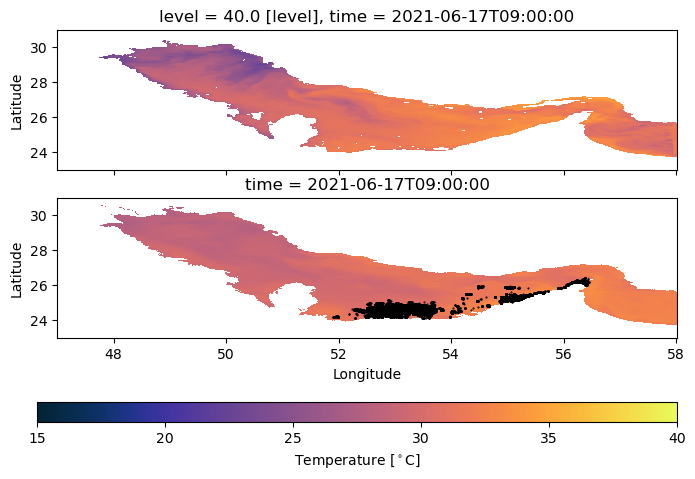

In [14]:
file0 = 'model_satellite/' + yr + '_surf_GETM_marv.nc'
fm_M = xr.open_dataset(file0)
#surface only
fmm2_M=fm_M.isel(level=0)

file0 = 'model_satellite/2021_surf_GETM_erav3.nc'

fm = xr.open_dataset(file0)

fmm2=fm.isel(level=0) #original

df=df.dropna(subset=['Latitude_1'])
df = df[df['ext_temperature_C'] <= 35]
df = df[df['ext_temperature_C'] > 5]

files=glob.glob('model_satellite/' + yr + '_satellite/' + yr + '*subset.nc')
fd=xr.open_mfdataset(files)
sst=fd.analysed_sst-273.15
sst.attrs["units"]="deg C"
sst.attrs["long_name"]="Sea Surface Temperature"
    
fig2,ax_1 = plt.subplots(3,1,figsize=(4, 8),sharey=True,sharex=True)

df['date']=pd.to_datetime(df['date'],format='%Y-%m-%d %H:%M:%S')

x = xr.DataArray(df.Longitude_1, dims="z")
y = xr.DataArray(df.Latitude_1, dims="z")
t = xr.DataArray(df.date, dims="z")
temp = xr.DataArray(df.ext_temperature_C, dims="z")
conduc = xr.DataArray(df['conductivity_mS/cm'], dims="z")

fmm=fmm2.temp.interp(lonc=x,latc=y,time=t) #original
fmm_M=fmm2_M.temp.interp(lonc=x,latc=y,time=t) #Marvin

sat_t=sst.interp(time=t,lat=y,lon=x)

# r=sqrt(sum((obs(:)-est(:)).^2)/numel(obs));

ax_1[0].plot(fmm,df.ext_temperature_C,'ko',markersize = ms1)
# ax_1[0].plot(fmm_M,df.ext_temperature_C,'ro',markersize = ms1)
ax_1[1].plot(sat_t,df.ext_temperature_C,'ko',markersize = ms1)
ax_1[2].plot(sat_t,fmm,'ko',markersize = ms1,label='ERA5_modified')
# ax_1[2].plot(sat_t,fmm_M,'ro',markersize = ms1,label='Modified')
ax_1[2].legend()
plt.xlim([CLim_l, CLim_h]),plt.ylim([CLim_l, CLim_h])

print('Satellite vs. bird: ' + str(RMSE(sat_t,df.ext_temperature_C)))
print('Orig model vs. bird: ' + str(RMSE(fmm,df.ext_temperature_C)))
print('Modified model vs. bird: ' + str(RMSE(fmm_M,df.ext_temperature_C)))
# RMSE(sat_t,asd)

for aa in np.arange(3):
    ax_1[aa].plot([CLim_l,CLim_h],[CLim_l,CLim_h])
    ax_1[aa].set_ylabel('birds')
    ax_1[aa].grid()
ax_1[0].set_xlabel(file0[-7:-3]  + ' model'),ax_1[2].set_ylabel('model')
ax_1[1].set_xlabel('satellite'),ax_1[2].set_xlabel('satellite')

plt.tight_layout()
# plt.savefig('figs/birdcomp_' + file1[:-4] + file0[-8:-3] + 'n.png', dpi=300, transparent=False, bbox_inches='tight')

# tt=df.date.dt.strftime('%Y-%m-%d')
# tt=tt.min()
fm2=fm.sel(time=sst.time[ptime], method='nearest')
fm3=fm2#.isel(level=40)

fig,ax = plt.subplots(2,1,figsize=(8, 4),sharey=True,sharex=True)

# fm2.temp.ax.plot()

a = fm3.temp.plot(ax=ax[0],add_colorbar=False, vmin=CLim_l, vmax=CLim_h,cmap=cmocean.cm.thermal)
ax[0].set(xlabel=None,ylabel='Latitude')
sst[ptime].plot(ax=ax[1],add_colorbar=False, vmin=CLim_l, vmax=CLim_h,cmap=cmocean.cm.thermal)
ax[1].set(xlabel='Longitude',ylabel='Latitude')
ax[1].plot(df.Longitude_1,df.Latitude_1,'ko',markersize = 0.5)
# plt.xlim([50, 54]),plt.ylim([23.5, 27.5]),
# cbar_kwargs={
#     "orientation": "horizontal",
#     "shrink": 0.8,
#     "aspect": 40,
#     "pad": 0.2,
# })
# plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
# plt.tight_layout()
cbar_ax = fig.add_axes([0.1, -0.1, .8, .05]) #left, bottom, width, height
fig.colorbar(a, cax=cbar_ax , orientation="horizontal",label="Temperature [$^\circ$C]")
# ff=f.split('/')
# f=ff[1].split('-')
# plt.savefig('figs/comp' + file1[:-4] + file0[-8:-3] + 'n.png', dpi=300, transparent=False, bbox_inches='tight')

# Some extra satellite vs model comparisons
# Make sure not to use same data points, i.e., don't ask for pre-/post- model data

# startdate = pd.Timestamp('2021-04-25 09:00:00')
# ts = [startdate + pd.Timedelta('5 days')*i for i in range(12)]

# # timmmm='2021-06-15 09:00:00'
# fm_sat=fm.sel(time=ts, method='nearest')

# sst_1=sst.sel(time=ts, method='nearest')

# fm_sat=fm_sat.interp(lonc=sst_1.lon,latc=sst_1.lat)

# aaa=sst_1-fm_sat

# aaa.temp[1].plot()

# g_simple = aaa.temp.plot(x='lon', y='lat', col='time', col_wrap=4)

In [375]:
idplt = 203018

x = ds_obs.x.where(ds_obs['id']==idplt,drop=True)
y = ds_obs.y.where(ds_obs['id']==idplt,drop=True)
t = ds_obs.t.where(ds_obs['id']==idplt,drop=True)
# ds_obs

# =ds_sur_era_v6.temp.interp(lonc=x,latc=y,time=t) #original

sat_t_tag1=sst.interp(time=t,lat=y,lon=x)

sat_t_tag1_clim = ds_mur_clim.sst.interp(time=t,lat=y,lon=x)-273.15

In [376]:
dust_dens_tag1 = ds_dust.interp(time=t,lat=y,lon=x)

dust_dens_tag1_daily = dust_dens_tag1.groupby('time.dayofyear').mean('t')

In [377]:
sat_t_tag1_daily = sat_t_tag1.groupby('time.dayofyear').mean('t')

sat_t_tag1_clim_daily = sat_t_tag1_clim.groupby('time.dayofyear').mean('t')

tag_t_daily = ds_obs['temp'].where(ds_obs['id']==idplt,drop=True).groupby("t.dayofyear").mean(dim='t')

# (tag_t_daily-sat_t_tag1_clim_daily).plot()
# plt.ylim(-5,5)

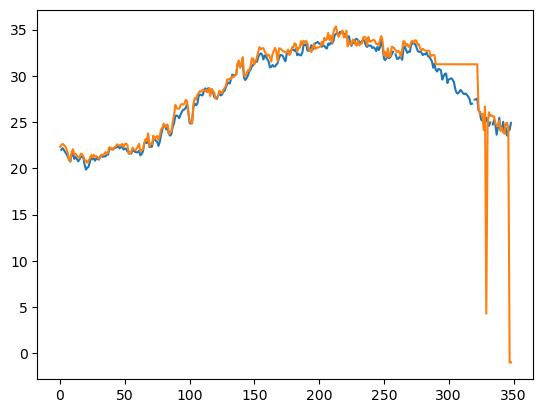

In [378]:
plt.plot(sat_t_tag1_daily)
plt.plot(tag_t_daily)

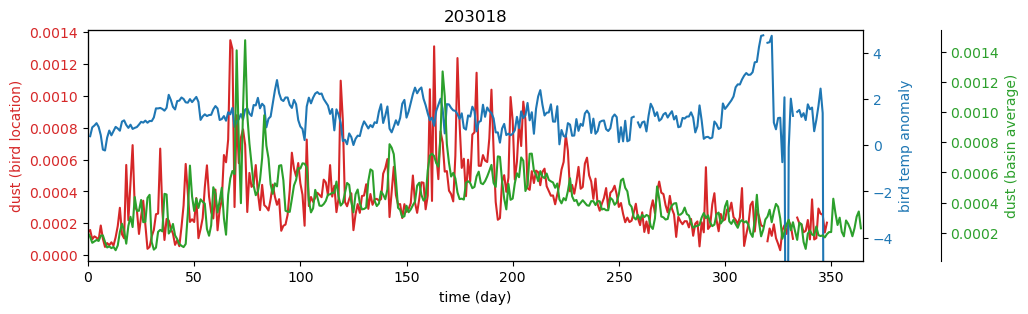

In [451]:
fig, ax1 = plt.subplots(figsize=(10,3))

color = 'tab:red'
ax1.set_xlabel('time (day)')
ax1.set_ylabel('dust (bird location)', color=color)
# ax1.plot(dustplt-da_dust_clim_avg.data, color=color)
# ax1.plot(dustplt, color='green')
ax1.plot(dust_dens_tag1_daily.dust_dens, color=color)
# ax1.set_xlim(50,150)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('bird temp anomaly', color=color)  # we already handled the x-label with ax1
# ax2.plot(np.arange(5,354),(tag_t_daily-sat_t_tag1_clim_daily), color=color)
ax2.plot((tag_t_daily-sat_t_tag1_clim_daily), color=color)
# ax2.plot((sat_t_tag1_daily-sat_t_tag1_clim_daily), color=color)
ax2.set_ylim(-5,5)
ax2.set_xlim(0,365)
ax2.tick_params(axis='y', labelcolor=color)
plt.title(str(idplt))

ax3 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax3.spines.right.set_position(("axes", 1.1))
color = 'tab:green'
ax3.set_ylabel('dust (basin average)', color=color)  # we already handled the x-label with ax1
# ax2.plot(np.arange(5,354),(tag_t_daily-sat_t_tag1_clim_daily), color=color)
# ax3.plot((tag_t_daily-sat_t_tag1_clim_daily), color=color)
ax3.plot(dustplt, color=color)
# ax2.plot((sat_t_tag1_daily-sat_t_tag1_clim_daily), color=color)
# ax3.set_ylim(-5,5)
ax3.set_xlim(0,365)
ax3.tick_params(axis='y', labelcolor=color)
# plt.title(str(idplt))

NameError: name 'dustplt' is not defined

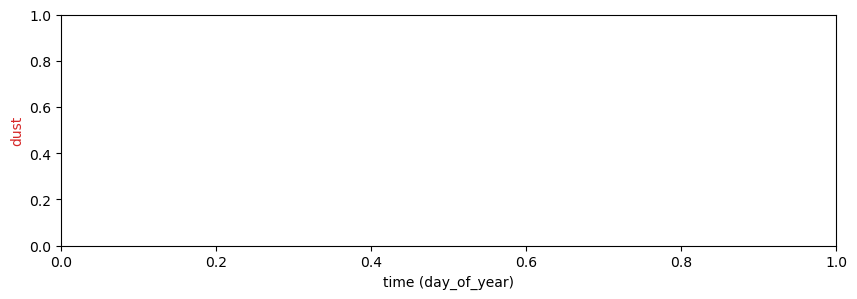

In [480]:
fig, ax1 = plt.subplots(figsize=(10,3))

color = 'tab:red'
ax1.set_xlabel('time (day_of_year)')
ax1.set_ylabel('dust', color=color)
ax1.plot(dustplt, color=color)
# ax1.plot(ta0, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('bird temperature anomaly', color=color)  # we already handled the x-label with ax1
# ax2.plot(ta0, color=color)
ax2.plot((tag_t_daily-sat_t_tag1_clim_daily), color=color)
ax2.set_ylim(-5,5)
ax2.tick_params(axis='y', labelcolor=color)
# ax2.set_ylim(180,400)
# ax2.set_xlim(0,300)
plt.title(str(idplt))

ax3 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

ax3.spines.right.set_position(("axes", 1.1))

color = 'tab:green'
ax3.set_ylabel('bird conductivity', color=color)  # we already handled the x-label with ax1
ax3.plot(ca0, color=color)
ax3.tick_params(axis='y', labelcolor=color)
ax3.set_ylim(180,400)
ax3.set_xlim(0,300)
plt.title(str(idplt))

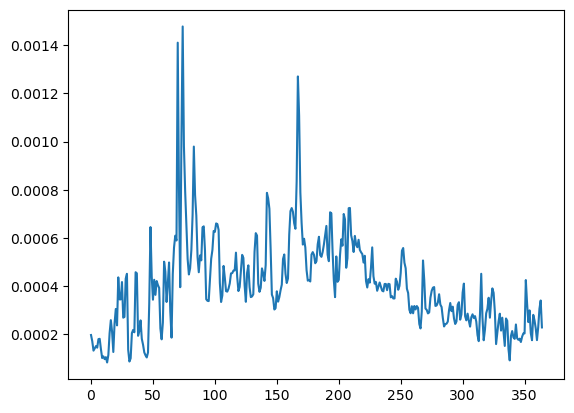

In [449]:
plt.plot(dustplt)

Text(0.5, 1.0, '203018')

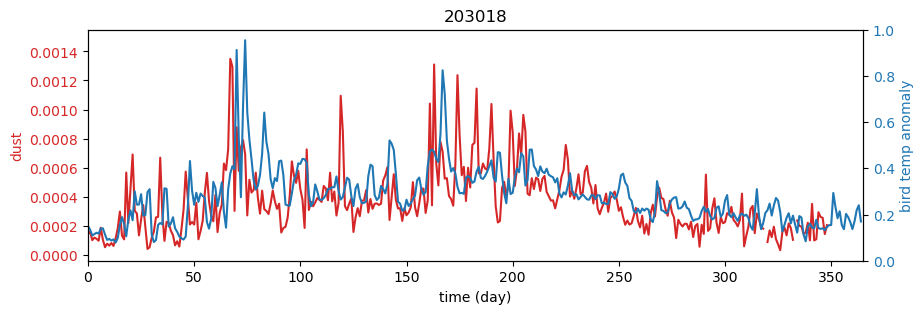

In [452]:
fig, ax1 = plt.subplots(figsize=(10,3))

color = 'tab:red'
ax1.set_xlabel('time (day)')
ax1.set_ylabel('dust', color=color)
# ax1.plot(dustplt-da_dust_clim_avg.data, color=color)
# ax1.plot(dustplt, color=color)
ax1.plot(dust_dens_tag1_daily.dust_dens, color=color)
# ax1.set_xlim(50,150)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('bird temp anomaly', color=color)  # we already handled the x-label with ax1
# ax2.plot((tag_t_daily-sat_t_tag1_clim_daily), color=color)
ax1.plot(dustplt, color=color)
# ax2.plot((sat_t_tag1_daily-sat_t_tag1_clim_daily), color=color)
# ax2.set_ylim(-5,5)
ax2.set_xlim(0,365)
ax2.tick_params(axis='y', labelcolor=color)
plt.title(str(idplt))

Text(0.5, 1.0, '201420')

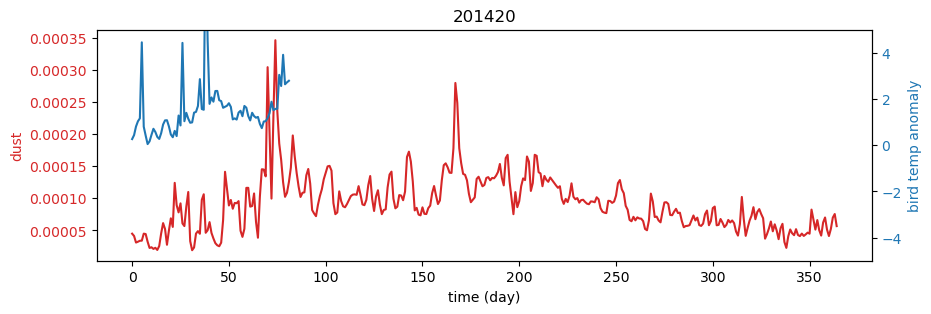

In [357]:
fig, ax1 = plt.subplots(figsize=(10,3))

color = 'tab:red'
ax1.set_xlabel('time (day)')
ax1.set_ylabel('dust', color=color)
# ax1.plot(dustplt-da_dust_clim_avg.data, color=color)
ax1.plot(dustplt, color=color)
# ax1.set_xlim(50,150)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('bird temp anomaly', color=color)  # we already handled the x-label with ax1
ax2.plot((tag_t_daily-sat_t_tag1_clim_daily), color=color)
# ax2.plot((sat_t_tag1_daily-sat_t_tag1_clim_daily), color=color)
ax2.set_ylim(-5,5)
# ax2.set_xlim(50,150)
ax2.tick_params(axis='y', labelcolor=color)
plt.title(str(idplt))

(68.0, 90.0)

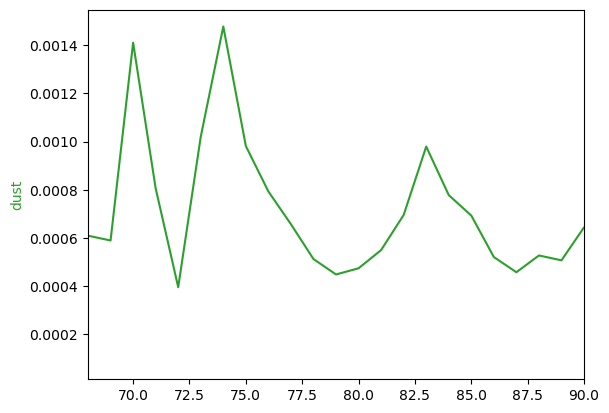

In [462]:
plt.ylabel('dust', color=color)
plt.plot(dustplt, color=color)
plt.xlim(68,90)

In [36]:
year=2021
day_of_year=79
pd.to_datetime(f"{year}-{day_of_year}", format="%Y-%j")

Timestamp('2021-03-20 00:00:00')

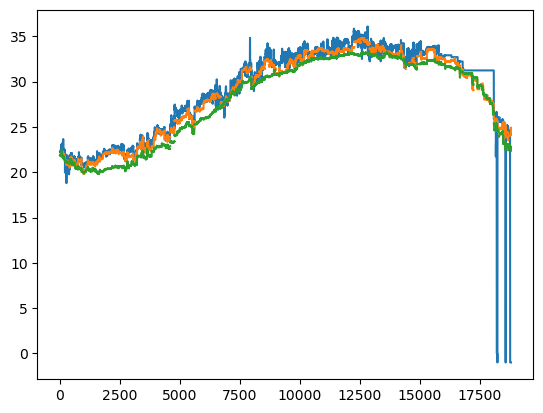

In [194]:
plt.plot(ds_obs.temp.where(ds_obs['id']==idplt,drop=True))
plt.plot(sat_t_tag1)
plt.plot(sat_t_tag1_clim)

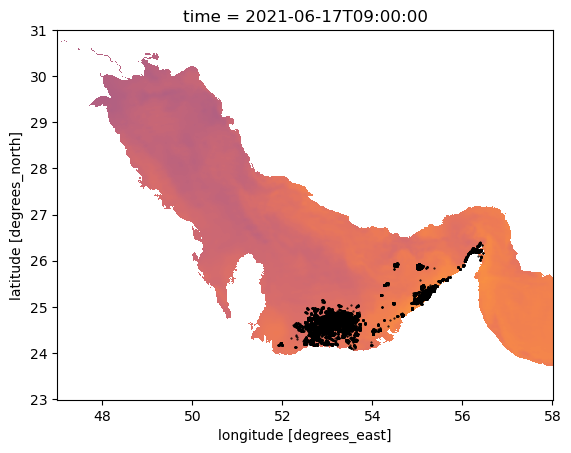

In [20]:
# plt.figure()
sst[ptime].plot(add_colorbar=False, vmin=CLim_l, vmax=CLim_h,cmap=cmocean.cm.thermal)
plt.plot(df.Longitude_1,df.Latitude_1,'ko',markersize = 0.5)
# plt.show()

In [511]:
df.where(df['device_id']==203018,drop='True')

TypeError: DataFrame.where() got an unexpected keyword argument 'drop'

In [316]:
# day_of_year=83
# year=2021

# (ds_dust_daily.dust_dens*mask_pg2.isel(TIME=0)).isel(dayofyear=day_of_year).plot.contourf(levels=np.arange(0,1.1e-3,1e-4))

# date_0 = pd.to_datetime(f"{year}-{day_of_year}", format="%Y-%j")
# date_1 = pd.to_datetime(f"{year}-{day_of_year+1}", format="%Y-%j")

# xpl = ds_obs.x.where(ds_obs['id']==idplt,drop=True).sel(t=slice(date_0,date_1))
# ypl = ds_obs.y.where(ds_obs['id']==idplt,drop=True).sel(t=slice(date_0,date_1))
# plt.plot(xpl,ypl,color='red')

In [315]:
# day_of_year=78

# g_simple = (ds_dust_daily.dust_dens*mask_pg2.isel(TIME=0)).isel(dayofyear=slice(day_of_year,day_of_year+12))\
#                        .plot(x="lon", \
#                              y="lat", \
#                              col="dayofyear", \
#                              col_wrap=3,\
#                              levels=np.arange(0,1.1e-3,1e-4))

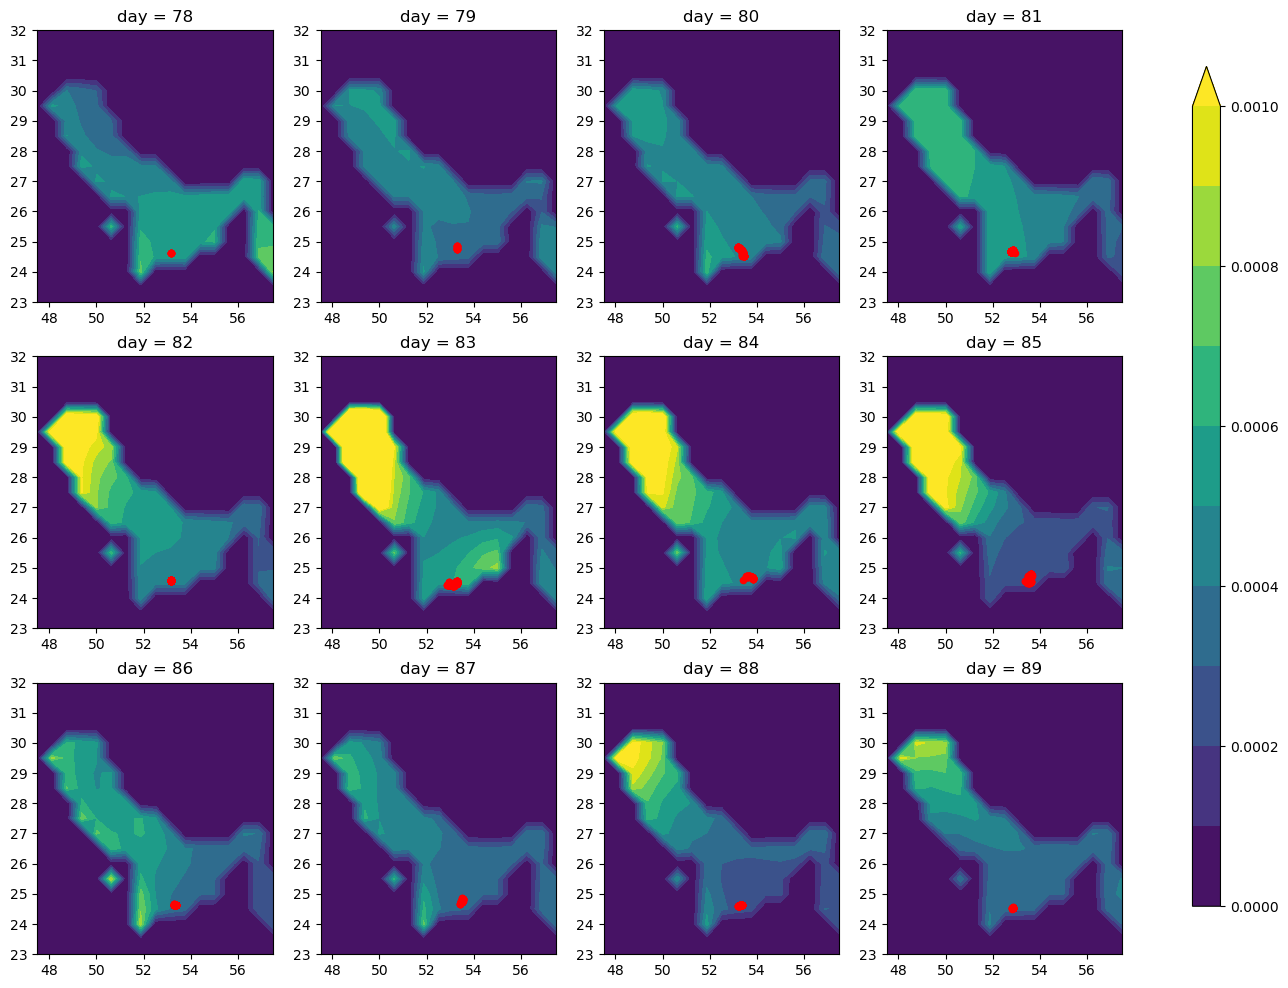

In [326]:
fig, axs = plt.subplots(3,4,figsize=[14,12])
day_of_year=78
year = 2021

for i in range(3):
    for j in range(4):
        ik = i*4+j
#     axs[j,i]
        im=axs[i,j].contourf(ds_dust_daily.lon, \
                      ds_dust_daily.lat, \
                      (ds_dust_daily.dust_dens*mask_pg2.isel(TIME=0)).isel(dayofyear=day_of_year+ik),\
                    levels=np.arange(0,1.1e-3,1e-4),vmin=0,vmax=1.e-3,extend='max')
        axs[i,j].set_title(f'day = {day_of_year+ik}')
        
        date_0 = pd.to_datetime(f"{year}-{day_of_year+ik}", format="%Y-%j")
        date_1 = pd.to_datetime(f"{year}-{day_of_year+ik+1}", format="%Y-%j")

        xpl = ds_obs.x.where(ds_obs['id']==idplt,drop=True).sel(t=slice(date_0,date_1))
        ypl = ds_obs.y.where(ds_obs['id']==idplt,drop=True).sel(t=slice(date_0,date_1))
        axs[i,j].scatter(xpl,ypl,s=20,color='red')
    
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.95, 0.15, 0.02, 0.7])
fig.colorbar(im, cax=cbar_ax)



In [492]:
import cartopy.crs as ccrs

/home/server/pi/homes/liux8/.conda/envs/dev_scipy/lib/python3.11/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


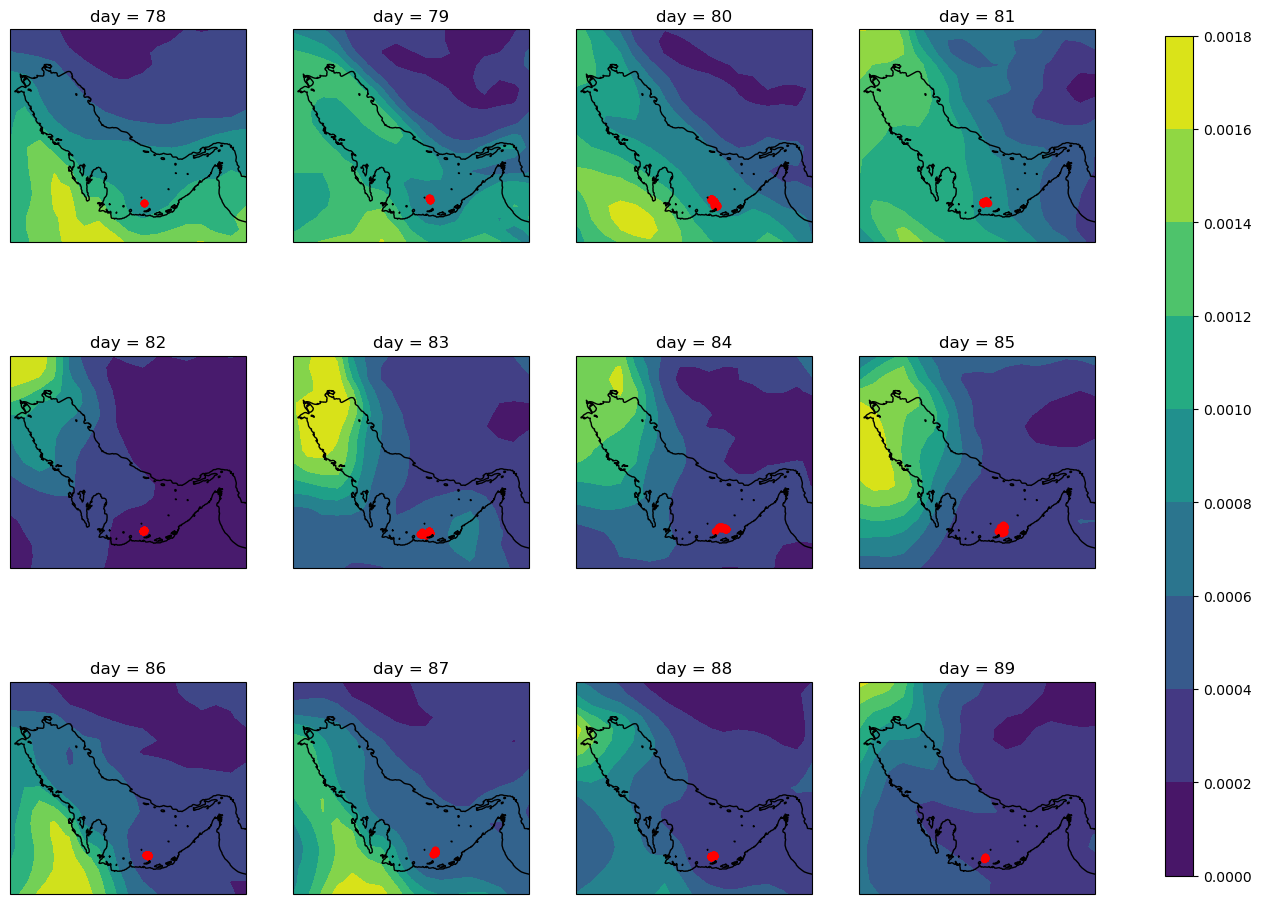

In [495]:
fig, axs = plt.subplots(3,4,figsize=[14,12],subplot_kw=dict(projection=ccrs.PlateCarree()))
day_of_year=78
year = 2021

for i in range(3):
    for j in range(4):
        ik = i*4+j
#     axs[j,i]
        im=axs[i,j].contourf(ds_dust_daily.lon, \
                      ds_dust_daily.lat, \
                      (ds_dust_daily.dust_dens).isel(dayofyear=day_of_year+ik),\
                   transform=ccrs.PlateCarree())
        axs[i,j].set_title(f'day = {day_of_year+ik}')
        axs[i,j].coastlines()
        
        date_0 = pd.to_datetime(f"{year}-{day_of_year+ik}", format="%Y-%j")
        date_1 = pd.to_datetime(f"{year}-{day_of_year+ik+1}", format="%Y-%j")

        xpl = ds_obs.x.where(ds_obs['id']==idplt,drop=True).sel(t=slice(date_0,date_1))
        ypl = ds_obs.y.where(ds_obs['id']==idplt,drop=True).sel(t=slice(date_0,date_1))
        axs[i,j].scatter(xpl,ypl,s=20,color='red')
    
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.95, 0.15, 0.02, 0.7])
fig.colorbar(im, cax=cbar_ax)



In [224]:
# ds_mur_clim.sel(lat=slice(22.99,31.01))

ds_mur_clim['time'] = ds_mur_clim['time']+np.timedelta64(9, 'h')
# ds_mur_clim['time']
# pd.DateOffset(hours=9)

In [314]:
# day_of_year=78

# g_simple = (sst-ds_mur_clim.sst+273.15).isel(time=slice(day_of_year,day_of_year+12))\
#                        .plot(x="lon", \
#                              y="lat", \
#                              col="time", \
#                              col_wrap=3,\
#                              levels=np.arange(-2,2,0.2))

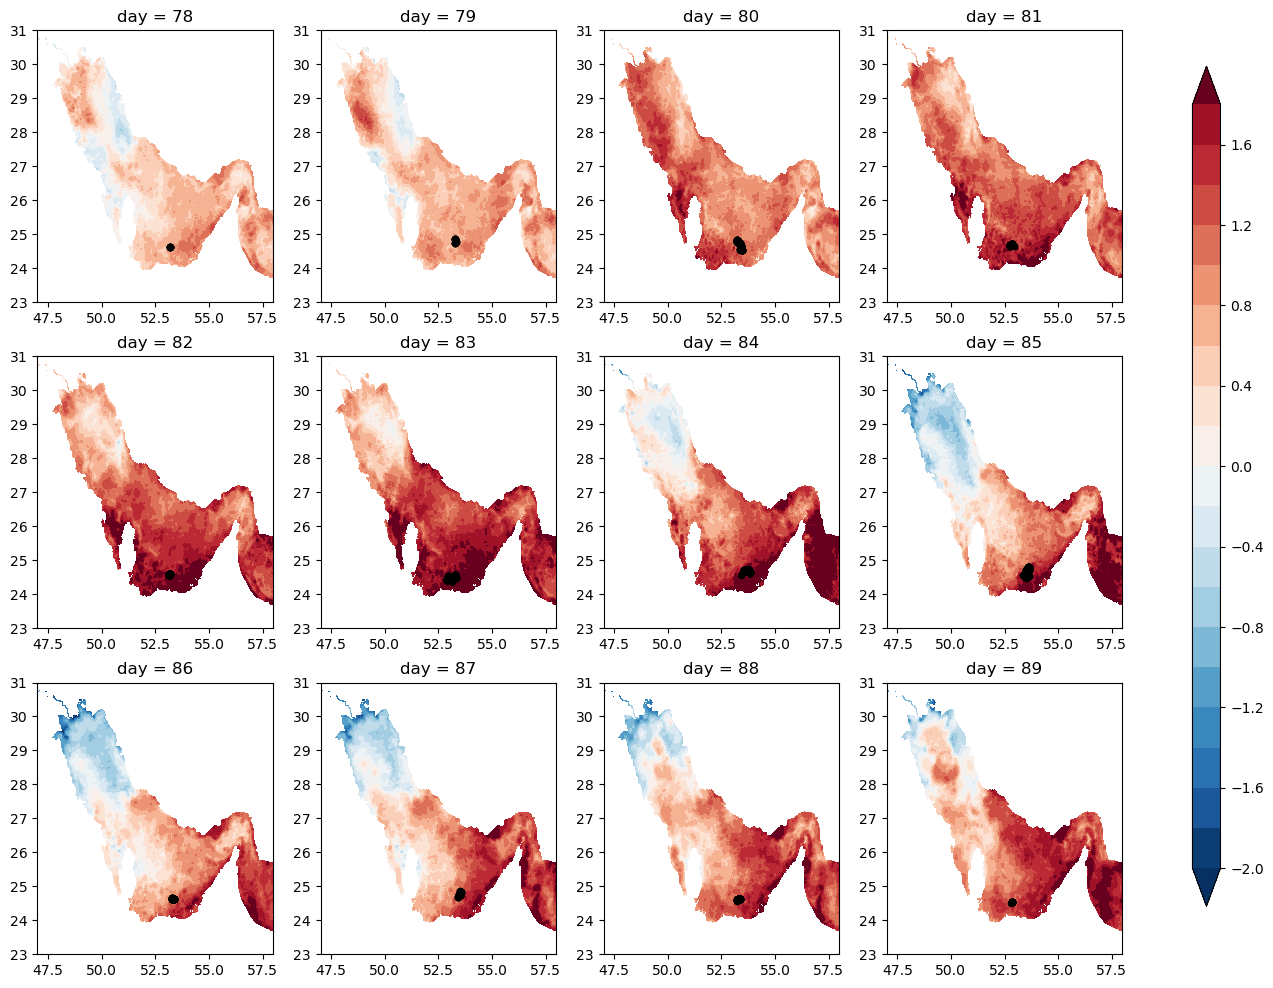

In [324]:
ssta_hor = sst-ds_mur_clim.sst+273.15

fig, axs = plt.subplots(3,4,figsize=[14,12])
day_of_year=78
year = 2021

for i in range(3):
    for j in range(4):
        ik = i*4+j
        im=axs[i,j].contourf(ssta_hor.lon, \
                      ssta_hor.lat, \
                      ssta_hor.isel(time=day_of_year+ik),\
                     levels=np.arange(-2,2,0.2),vmin=-2,vmax=2,extend='both',\
                            cmap='RdBu_r')
        axs[i,j].set_title(f'day = {day_of_year+ik}')
        
        date_0 = pd.to_datetime(f"{year}-{day_of_year+ik}", format="%Y-%j")
        date_1 = pd.to_datetime(f"{year}-{day_of_year+ik+1}", format="%Y-%j")

        xpl = ds_obs.x.where(ds_obs['id']==idplt,drop=True).sel(t=slice(date_0,date_1))
        ypl = ds_obs.y.where(ds_obs['id']==idplt,drop=True).sel(t=slice(date_0,date_1))
        axs[i,j].scatter(xpl,ypl,s=20,color='black')
    
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.95, 0.15, 0.02, 0.7])
fig.colorbar(im, cax=cbar_ax)

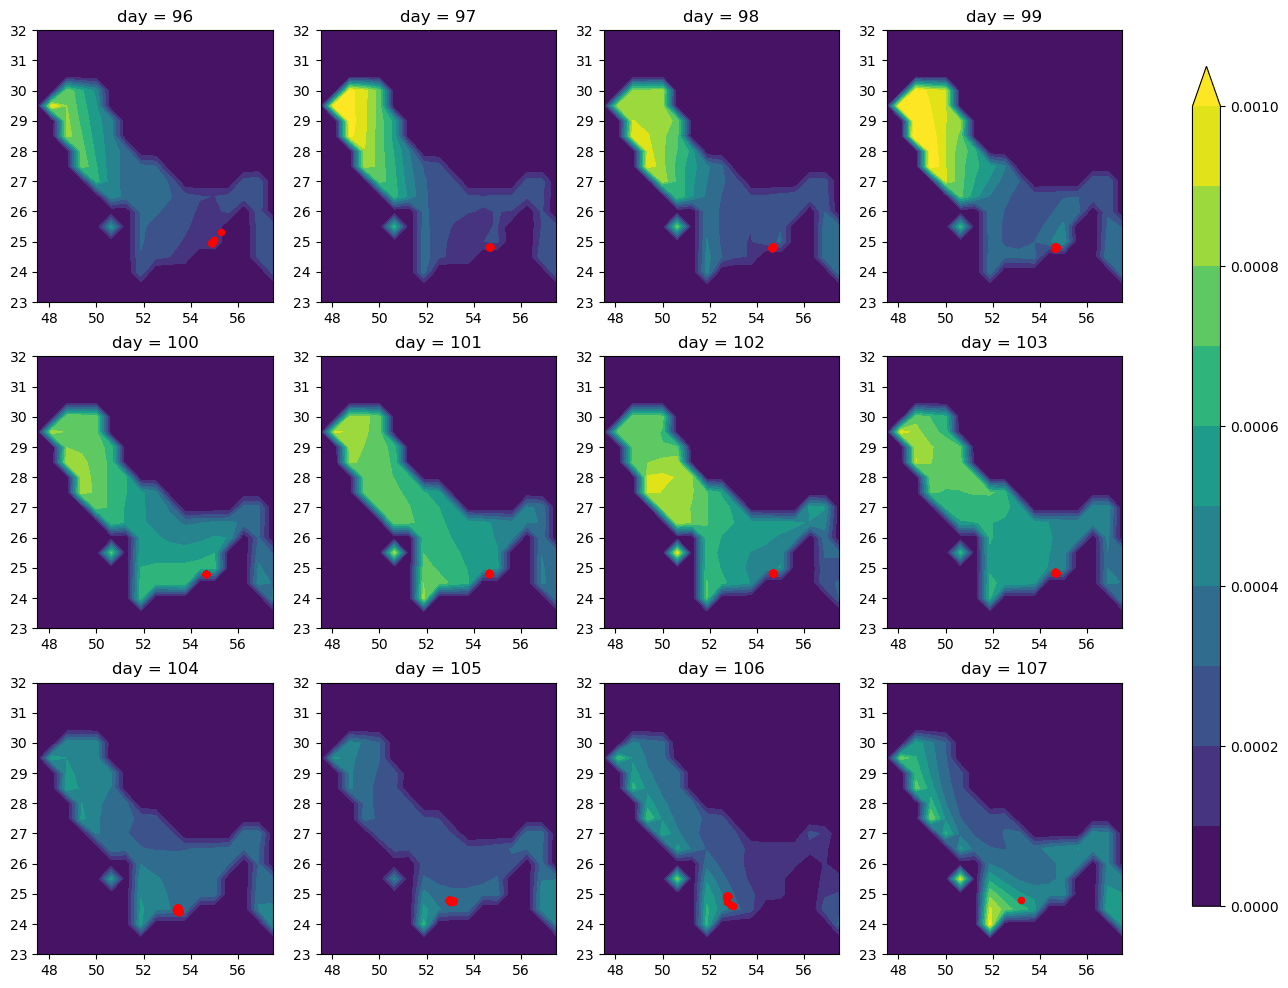

In [321]:
day_of_year=96
year = 2021

fig, axs = plt.subplots(3,4,figsize=[14,12])

for i in range(3):
    for j in range(4):
        ik = i*4+j
#     axs[j,i]
        im=axs[i,j].contourf(ds_dust_daily.lon, \
                      ds_dust_daily.lat, \
                      (ds_dust_daily.dust_dens*mask_pg2.isel(TIME=0)).isel(dayofyear=day_of_year+ik),\
                    levels=np.arange(0,1.1e-3,1e-4),vmin=0,vmax=1.e-3,extend='max')
        axs[i,j].set_title(f'day = {day_of_year+ik}')
        
        date_0 = pd.to_datetime(f"{year}-{day_of_year+ik}", format="%Y-%j")
        date_1 = pd.to_datetime(f"{year}-{day_of_year+ik+1}", format="%Y-%j")

        xpl = ds_obs.x.where(ds_obs['id']==idplt,drop=True).sel(t=slice(date_0,date_1))
        ypl = ds_obs.y.where(ds_obs['id']==idplt,drop=True).sel(t=slice(date_0,date_1))
        axs[i,j].scatter(xpl,ypl,s=20,color='red')
    
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.95, 0.15, 0.02, 0.7])
fig.colorbar(im, cax=cbar_ax)


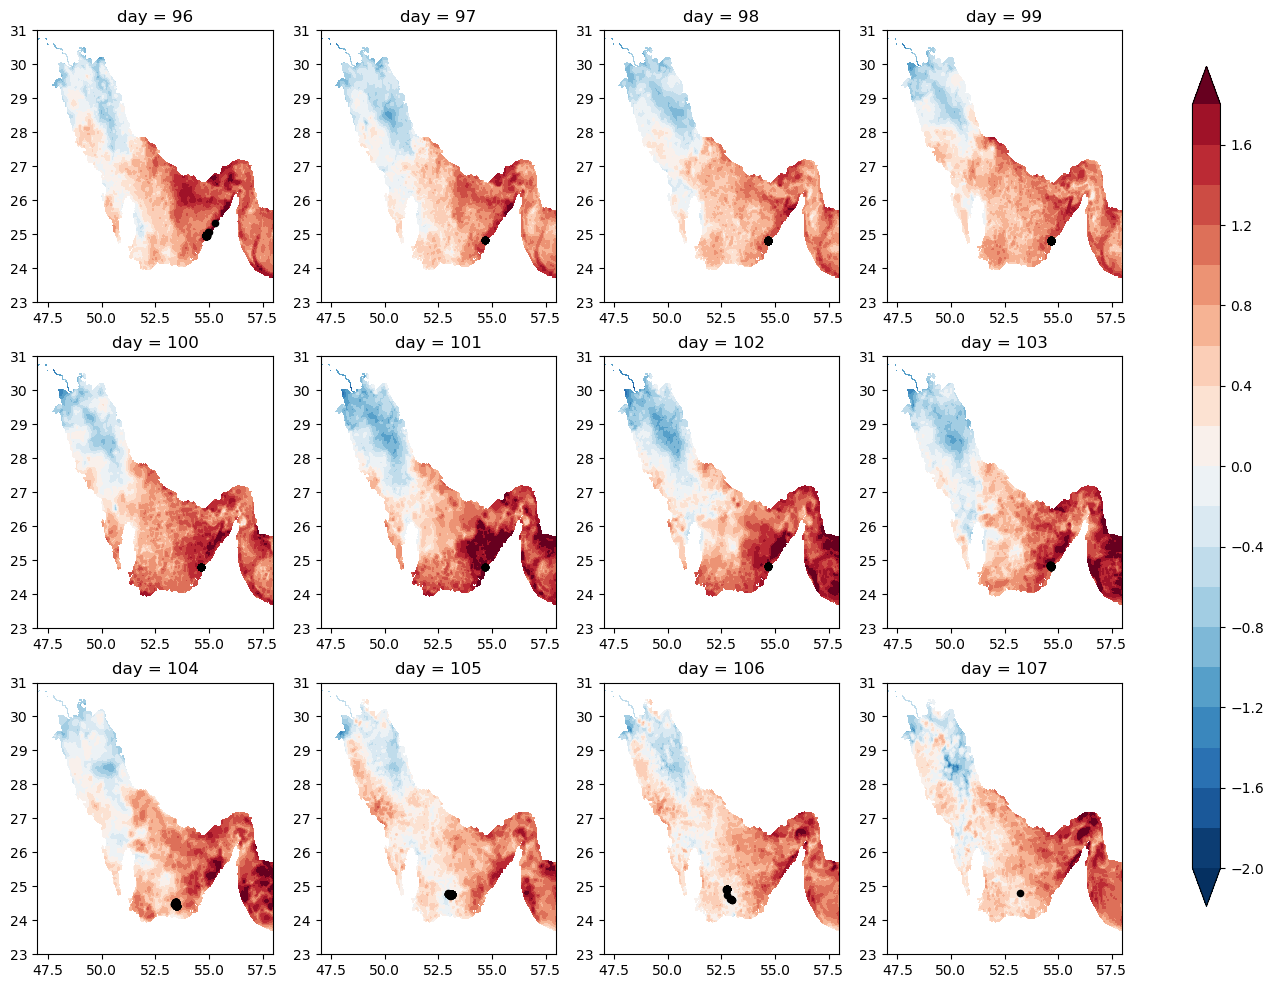

In [323]:
day_of_year=96
year = 2021

ssta_hor = sst-ds_mur_clim.sst+273.15

fig, axs = plt.subplots(3,4,figsize=[14,12])

for i in range(3):
    for j in range(4):
        ik = i*4+j
        im=axs[i,j].contourf(ssta_hor.lon, \
                      ssta_hor.lat, \
                      ssta_hor.isel(time=day_of_year+ik),\
                     levels=np.arange(-2,2,0.2),vmin=-2,vmax=2,extend='both',\
                            cmap='RdBu_r')
        axs[i,j].set_title(f'day = {day_of_year+ik}')
        
        date_0 = pd.to_datetime(f"{year}-{day_of_year+ik}", format="%Y-%j")
        date_1 = pd.to_datetime(f"{year}-{day_of_year+ik+1}", format="%Y-%j")

        xpl = ds_obs.x.where(ds_obs['id']==idplt,drop=True).sel(t=slice(date_0,date_1))
        ypl = ds_obs.y.where(ds_obs['id']==idplt,drop=True).sel(t=slice(date_0,date_1))
        axs[i,j].scatter(xpl,ypl,s=20,color='black')
    
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.95, 0.15, 0.02, 0.7])
fig.colorbar(im, cax=cbar_ax)


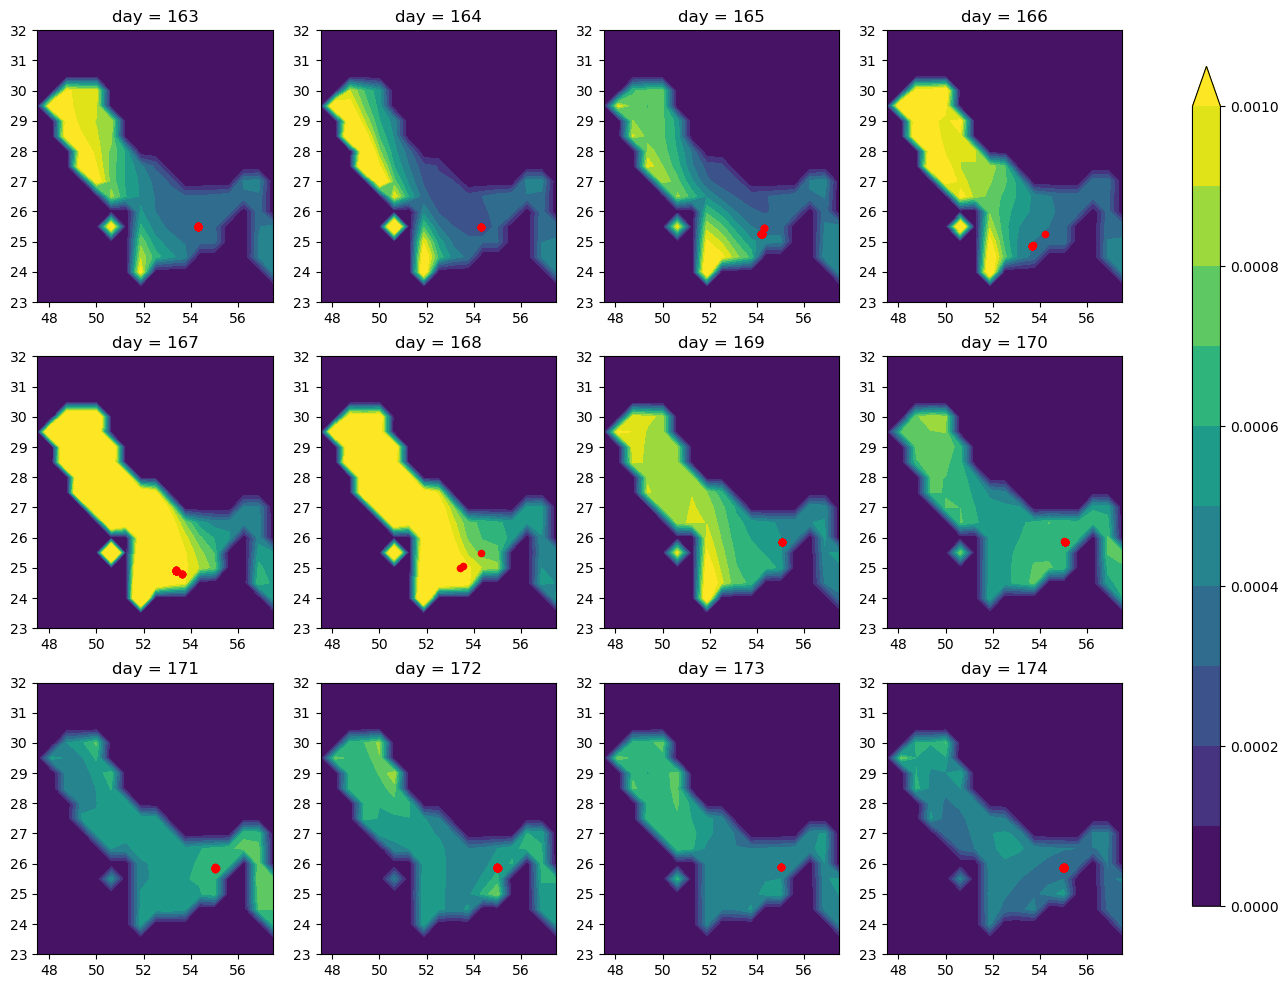

In [330]:
day_of_year=163
year = 2021

fig, axs = plt.subplots(3,4,figsize=[14,12])

for i in range(3):
    for j in range(4):
        ik = i*4+j
#     axs[j,i]
        im=axs[i,j].contourf(ds_dust_daily.lon, \
                      ds_dust_daily.lat, \
                      (ds_dust_daily.dust_dens*mask_pg2.isel(TIME=0)).isel(dayofyear=day_of_year+ik),\
                    levels=np.arange(0,1.1e-3,1e-4),vmin=0,vmax=1.e-3,extend='max')
        axs[i,j].set_title(f'day = {day_of_year+ik}')
        
        date_0 = pd.to_datetime(f"{year}-{day_of_year+ik}", format="%Y-%j")
        date_1 = pd.to_datetime(f"{year}-{day_of_year+ik+1}", format="%Y-%j")

        xpl = ds_obs.x.where(ds_obs['id']==idplt,drop=True).sel(t=slice(date_0,date_1))
        ypl = ds_obs.y.where(ds_obs['id']==idplt,drop=True).sel(t=slice(date_0,date_1))
        xpl = xpl.where(xpl!=0)
        ypl = ypl.where(ypl!=0)
        axs[i,j].scatter(xpl,ypl,s=20,color='red')
    
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.95, 0.15, 0.02, 0.7])
fig.colorbar(im, cax=cbar_ax)


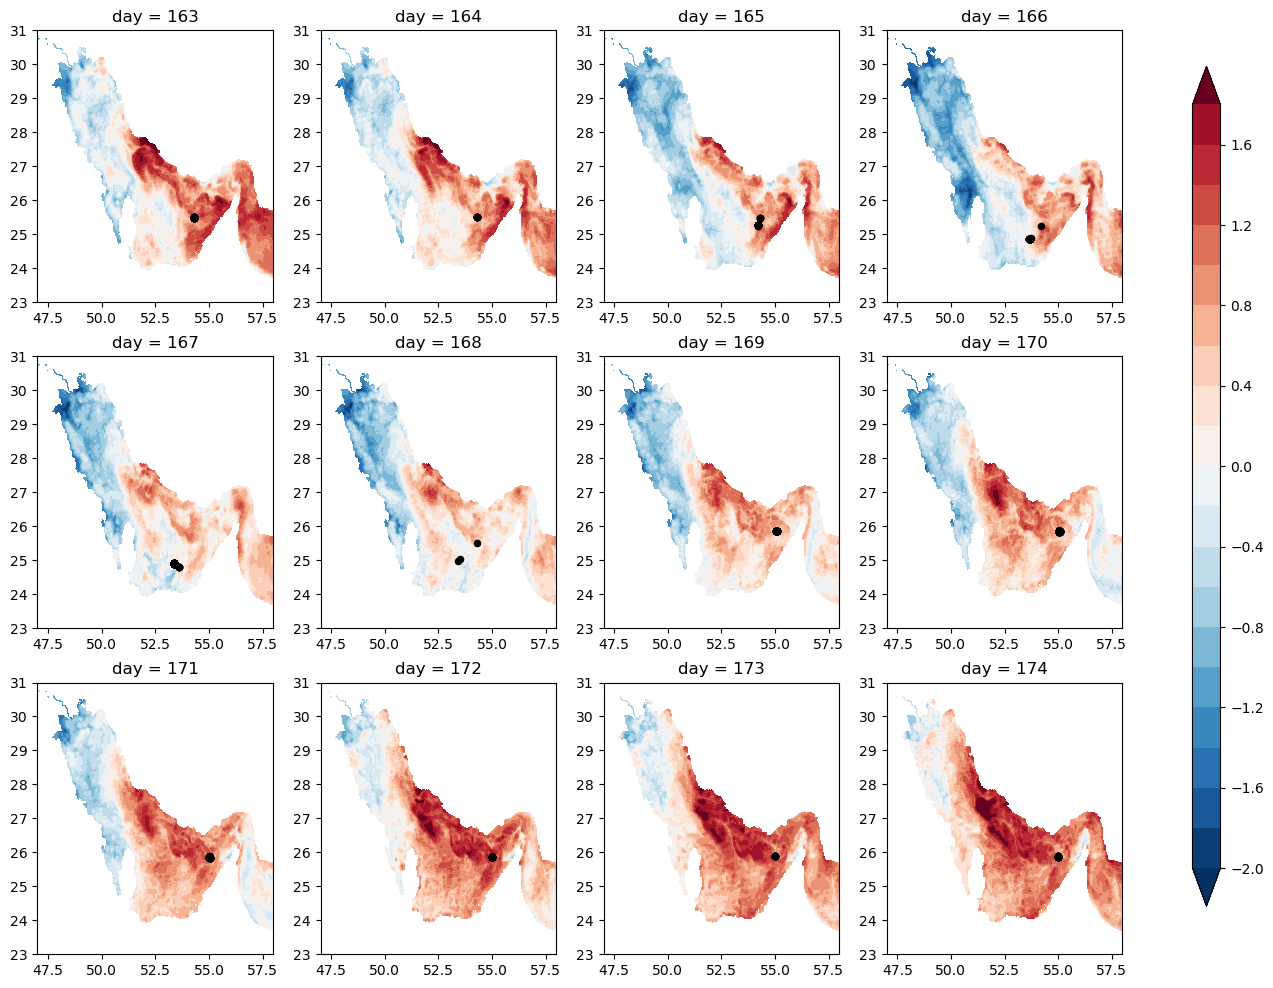

In [331]:
day_of_year=163
year = 2021

ssta_hor = sst-ds_mur_clim.sst+273.15

fig, axs = plt.subplots(3,4,figsize=[14,12])

for i in range(3):
    for j in range(4):
        ik = i*4+j
        im=axs[i,j].contourf(ssta_hor.lon, \
                      ssta_hor.lat, \
                      ssta_hor.isel(time=day_of_year+ik),\
                     levels=np.arange(-2,2,0.2),vmin=-2,vmax=2,extend='both',\
                            cmap='RdBu_r')
        axs[i,j].set_title(f'day = {day_of_year+ik}')
        
        date_0 = pd.to_datetime(f"{year}-{day_of_year+ik}", format="%Y-%j")
        date_1 = pd.to_datetime(f"{year}-{day_of_year+ik+1}", format="%Y-%j")

        xpl = ds_obs.x.where(ds_obs['id']==idplt,drop=True).sel(t=slice(date_0,date_1))
        ypl = ds_obs.y.where(ds_obs['id']==idplt,drop=True).sel(t=slice(date_0,date_1))
        xpl = xpl.where(xpl!=0)
        ypl = ypl.where(ypl!=0)
        axs[i,j].scatter(xpl,ypl,s=20,color='black')
    
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.95, 0.15, 0.02, 0.7])
fig.colorbar(im, cax=cbar_ax)

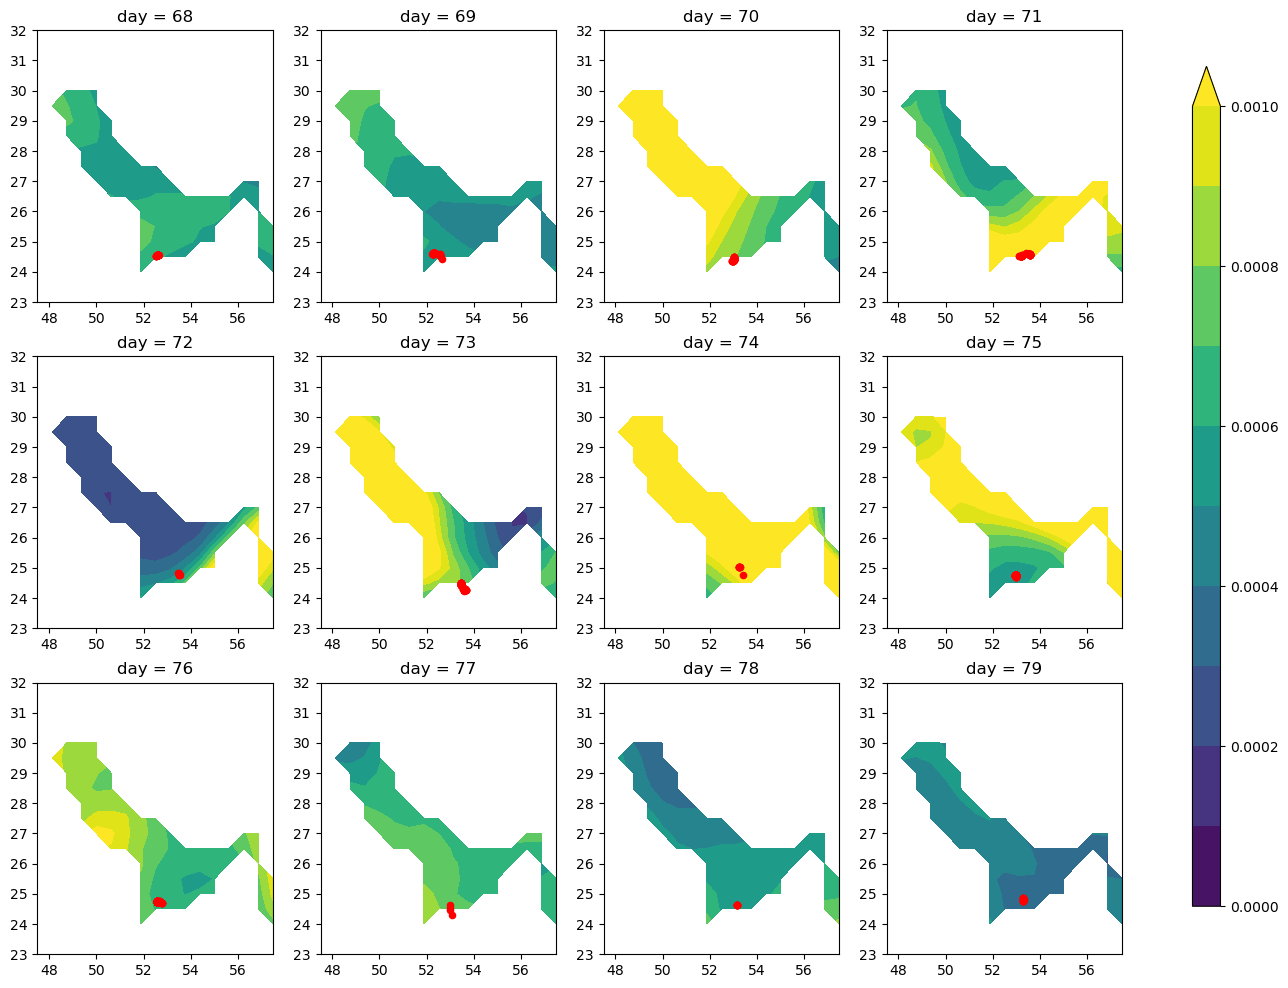

In [463]:
fig, axs = plt.subplots(3,4,figsize=[14,12])
day_of_year=68
year = 2021

for i in range(3):
    for j in range(4):
        ik = i*4+j
#     axs[j,i]
        im=axs[i,j].contourf(ds_dust_daily.lon, \
                      ds_dust_daily.lat, \
                      (ds_dust_daily.dust_dens*mask_pg2.isel(TIME=0)).isel(dayofyear=day_of_year+ik),\
                    levels=np.arange(0,1.1e-3,1e-4),vmin=0,vmax=1.e-3,extend='max')
        axs[i,j].set_title(f'day = {day_of_year+ik}')
        
        date_0 = pd.to_datetime(f"{year}-{day_of_year+ik}", format="%Y-%j")
        date_1 = pd.to_datetime(f"{year}-{day_of_year+ik+1}", format="%Y-%j")

        xpl = ds_obs.x.where(ds_obs['id']==idplt,drop=True).sel(t=slice(date_0,date_1))
        ypl = ds_obs.y.where(ds_obs['id']==idplt,drop=True).sel(t=slice(date_0,date_1))
        axs[i,j].scatter(xpl,ypl,s=20,color='red')
    
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.95, 0.15, 0.02, 0.7])
fig.colorbar(im, cax=cbar_ax)


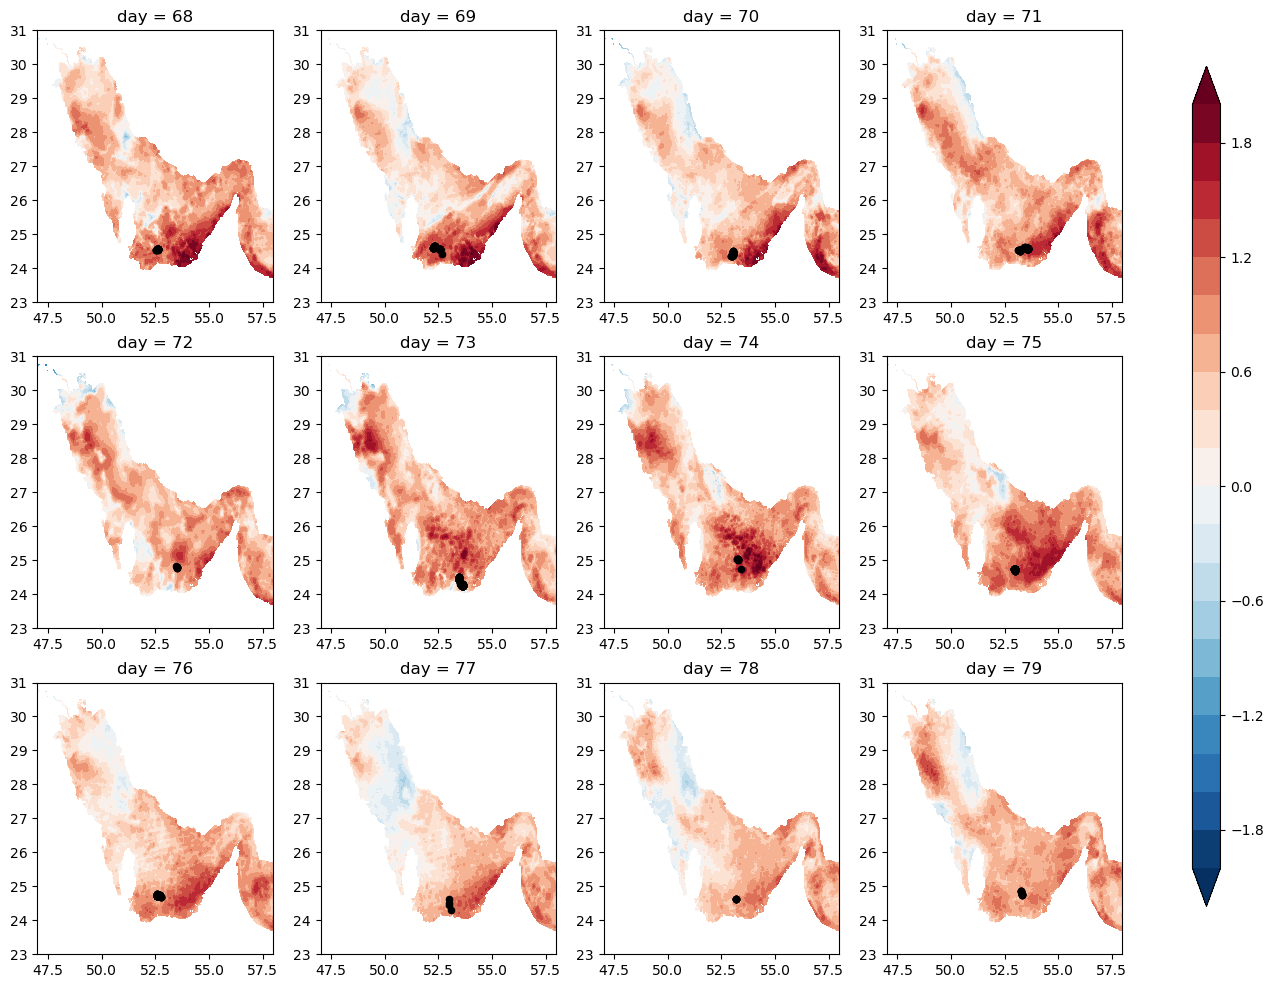

In [465]:
day_of_year=68
year = 2021

ssta_hor = sst-ds_mur_clim.sst+273.15

fig, axs = plt.subplots(3,4,figsize=[14,12])

for i in range(3):
    for j in range(4):
        ik = i*4+j
        im=axs[i,j].contourf(ssta_hor.lon, \
                      ssta_hor.lat, \
                      ssta_hor.isel(time=day_of_year+ik),\
                     levels=np.arange(-2,2.2,0.2),vmin=-2,vmax=2,extend='both',\
                            cmap='RdBu_r')
        axs[i,j].set_title(f'day = {day_of_year+ik}')
        
        date_0 = pd.to_datetime(f"{year}-{day_of_year+ik}", format="%Y-%j")
        date_1 = pd.to_datetime(f"{year}-{day_of_year+ik+1}", format="%Y-%j")

        xpl = ds_obs.x.where(ds_obs['id']==idplt,drop=True).sel(t=slice(date_0,date_1))
        ypl = ds_obs.y.where(ds_obs['id']==idplt,drop=True).sel(t=slice(date_0,date_1))
        xpl = xpl.where(xpl!=0)
        ypl = ypl.where(ypl!=0)
        axs[i,j].scatter(xpl,ypl,s=20,color='black')
    
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.95, 0.15, 0.02, 0.7])
fig.colorbar(im, cax=cbar_ax)

Text(0.5, 1.0, '203018')

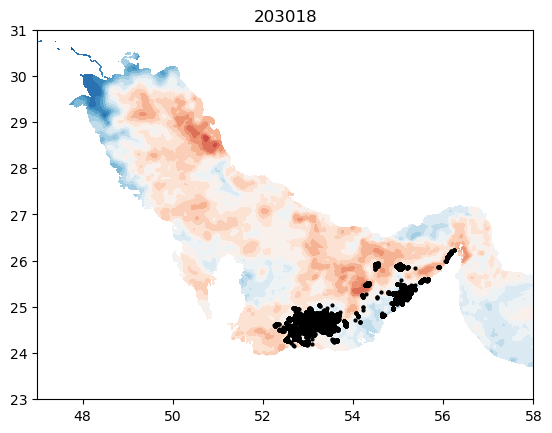

In [469]:
plt.contourf(ssta_hor.lon, \
                      ssta_hor.lat, \
                      ssta_hor.isel(time=0),\
                     levels=np.arange(-2,2.2,0.2),vmin=-2,vmax=2,extend='both',\
                            cmap='RdBu_r')        
date_0 = pd.to_datetime(f"{year}-{1}", format="%Y-%j")
date_1 = pd.to_datetime(f"{year}-{348}", format="%Y-%j")

xpl = ds_obs.x.where(ds_obs['id']==idplt,drop=True).sel(t=slice(date_0,date_1))
ypl = ds_obs.y.where(ds_obs['id']==idplt,drop=True).sel(t=slice(date_0,date_1))
xpl = xpl.where(xpl!=0)
ypl = ypl.where(ypl!=0)
plt.scatter(xpl,ypl,s=4,color='black')
plt.title(idplt)

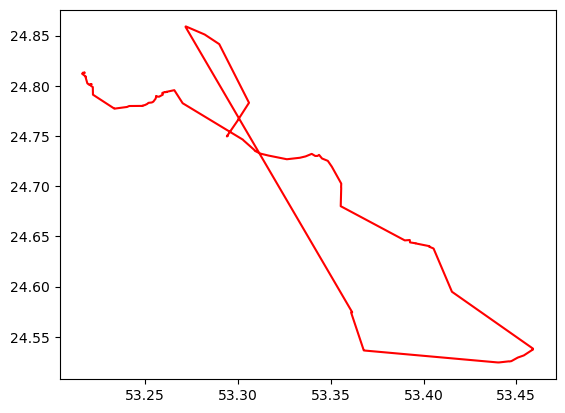

In [161]:
xpl = ds_obs.x.where(ds_obs['id']==idplt,drop=True).sel(t=slice('2021-03-20','2021-03-21'))
ypl = ds_obs.y.where(ds_obs['id']==idplt,drop=True).sel(t=slice('2021-03-20','2021-03-21'))

plt.plot(xpl,ypl,color='red')

In [1]:
sst[ptime].plot(add_colorbar=False, vmin=CLim_l, vmax=CLim_h,cmap=cmocean.cm.thermal)

plt.scatter(x,y,c=temp,vmin=CLim_l, vmax=CLim_h,cmap=cmocean.cm.thermal,markersize = 0.5)
plt.xlim([51, 58])
plt.ylim(23, 27)
plt.colorbar()

NameError: name 'sst' is not defined

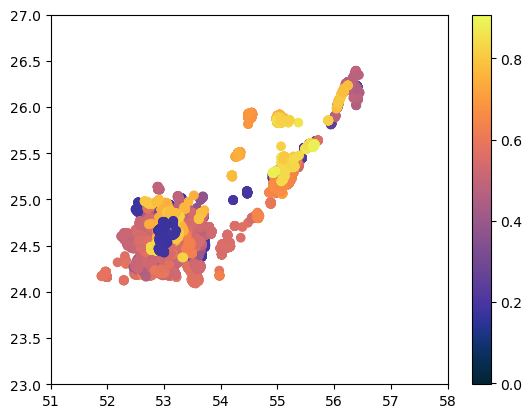

In [25]:
# sst[ptime].plot(add_colorbar=False, vmin=CLim_l, vmax=CLim_h,cmap=cmocean.cm.thermal)

plt.scatter(x,y,c=conduc/42.914*0.1,cmap=cmocean.cm.thermal)
plt.xlim([51, 58])
plt.ylim(23, 27)
plt.colorbar()

In [27]:
import gsw

In [31]:
t

<xarray.DataArray 'date' (z: 35560)>
array(['2021-01-01T05:08:38.000000000', '2021-01-01T05:09:49.000000000',
       '2021-01-01T05:11:14.000000000', ...,
       '2021-01-11T12:27:48.000000000', '2021-01-11T12:29:10.000000000',
       '2021-01-11T12:30:21.000000000'], dtype='datetime64[ns]')
Coordinates:
  * z        (z) datetime64[ns] 2021-01-01T05:08:38 ... 2021-01-11T12:30:21

In [34]:
s = gsw.SP_from_C(conduc.data,temp.data,temp.data*0)

In [37]:
c0 = gsw.C_from_SP(40,temp.data,temp.data*0)
c0

array([56.41621704, 56.39817841, 56.36210587, ..., 55.80379053,
       55.88474162, 56.06474833])

Satellite vs. bird: 0.8663084334662914
Orig model vs. bird: 1.0816432644980183
Modified model vs. bird: 1.0304284577012357


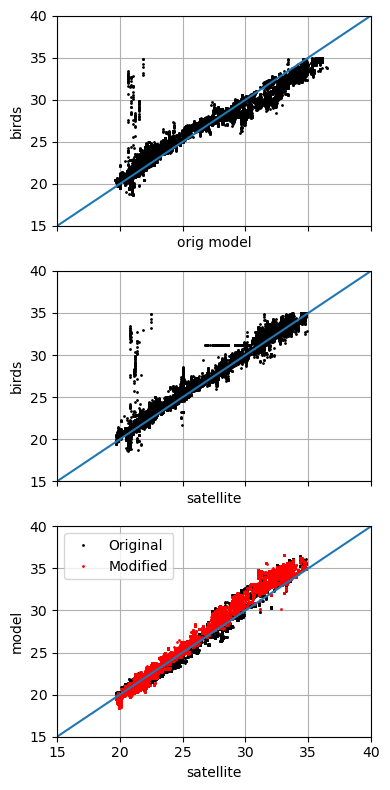

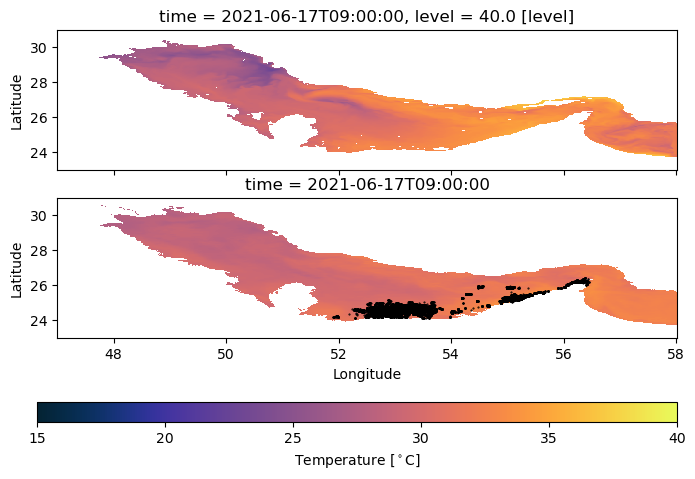

In [15]:
# file0 = 'model_satellite/' + yr + '_surf_GETM_marv.nc'
file0 = '/home/server/pi/homes/liux8/work/GETM/hpc2-files/GETM_shrad/getm/setups/era5frc_hotstart_01012021/data_002/regions/surface.nc'
fm_M = xr.open_dataset(file0)
#surface only
fmm2_M=fm_M.isel(level=0)

file0 = 'model_satellite/JanAug2021_surf_GETM_orig.nc'

fm = xr.open_dataset(file0)

fmm2=fm.isel(level=0) #original

df=df.dropna(subset=['Latitude_1'])
df = df[df['ext_temperature_C'] <= 35]
df = df[df['ext_temperature_C'] > 5]

files=glob.glob('model_satellite/' + yr + '_satellite/' + yr + '*subset.nc')
fd=xr.open_mfdataset(files)
sst=fd.analysed_sst-273.15
sst.attrs["units"]="deg C"
sst.attrs["long_name"]="Sea Surface Temperature"
    
fig2,ax_1 = plt.subplots(3,1,figsize=(4, 8),sharey=True,sharex=True)

df['date']=pd.to_datetime(df['date'],format='%Y-%m-%d %H:%M:%S')

x = xr.DataArray(df.Longitude_1, dims="z")
y = xr.DataArray(df.Latitude_1, dims="z")
t = xr.DataArray(df.date, dims="z")

fmm=fmm2.temp.interp(lonc=x,latc=y,time=t) #original
fmm_M=fmm2_M.temp.interp(lonc=x,latc=y,time=t) #Marvin

sat_t=sst.interp(time=t,lat=y,lon=x)

# r=sqrt(sum((obs(:)-est(:)).^2)/numel(obs));

ax_1[0].plot(fmm,df.ext_temperature_C,'ko',markersize = ms1)
# ax_1[0].plot(fmm_M,df.ext_temperature_C,'ro',markersize = ms1)
ax_1[1].plot(sat_t,df.ext_temperature_C,'ko',markersize = ms1)
ax_1[2].plot(sat_t,fmm,'ko',markersize = ms1,label='Original')
ax_1[2].plot(sat_t,fmm_M,'ro',markersize = ms1,label='Modified')
ax_1[2].legend()
plt.xlim([CLim_l, CLim_h]),plt.ylim([CLim_l, CLim_h])

print('Satellite vs. bird: ' + str(RMSE(sat_t,df.ext_temperature_C)))
print('Orig model vs. bird: ' + str(RMSE(fmm,df.ext_temperature_C)))
print('Modified model vs. bird: ' + str(RMSE(fmm_M,df.ext_temperature_C)))
# RMSE(sat_t,asd)

for aa in np.arange(3):
    ax_1[aa].plot([CLim_l,CLim_h],[CLim_l,CLim_h])
    ax_1[aa].set_ylabel('birds')
    ax_1[aa].grid()
ax_1[0].set_xlabel(file0[-7:-3]  + ' model'),ax_1[2].set_ylabel('model')
ax_1[1].set_xlabel('satellite'),ax_1[2].set_xlabel('satellite')

plt.tight_layout()
# plt.savefig('figs/birdcomp_' + file1[:-4] + file0[-8:-3] + 'n.png', dpi=300, transparent=False, bbox_inches='tight')

# tt=df.date.dt.strftime('%Y-%m-%d')
# tt=tt.min()
fm2=fm.sel(time=sst.time[ptime], method='nearest')
fm3=fm2#.isel(level=40)

fig,ax = plt.subplots(2,1,figsize=(8, 4),sharey=True,sharex=True)

# fm2.temp.ax.plot()

a = fm3.temp.plot(ax=ax[0],add_colorbar=False, vmin=CLim_l, vmax=CLim_h,cmap=cmocean.cm.thermal)
ax[0].set(xlabel=None,ylabel='Latitude')
sst[ptime].plot(ax=ax[1],add_colorbar=False, vmin=CLim_l, vmax=CLim_h,cmap=cmocean.cm.thermal)
ax[1].set(xlabel='Longitude',ylabel='Latitude')
ax[1].plot(df.Longitude_1,df.Latitude_1,'ko',markersize = 0.5)
# plt.xlim([50, 54]),plt.ylim([23.5, 27.5]),
# cbar_kwargs={
#     "orientation": "horizontal",
#     "shrink": 0.8,
#     "aspect": 40,
#     "pad": 0.2,
# })
# plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
# plt.tight_layout()
cbar_ax = fig.add_axes([0.1, -0.1, .8, .05]) #left, bottom, width, height
fig.colorbar(a, cax=cbar_ax , orientation="horizontal",label="Temperature [$^\circ$C]")
# ff=f.split('/')
# f=ff[1].split('-')
# plt.savefig('figs/comp' + file1[:-4] + file0[-8:-3] + 'n.png', dpi=300, transparent=False, bbox_inches='tight')

# Some extra satellite vs model comparisons
# Make sure not to use same data points, i.e., don't ask for pre-/post- model data

# startdate = pd.Timestamp('2021-04-25 09:00:00')
# ts = [startdate + pd.Timedelta('5 days')*i for i in range(12)]

# # timmmm='2021-06-15 09:00:00'
# fm_sat=fm.sel(time=ts, method='nearest')

# sst_1=sst.sel(time=ts, method='nearest')

# fm_sat=fm_sat.interp(lonc=sst_1.lon,latc=sst_1.lat)

# aaa=sst_1-fm_sat

# aaa.temp[1].plot()

# g_simple = aaa.temp.plot(x='lon', y='lat', col='time', col_wrap=4)